In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
# app = track_info['appearances']
def get_real_dict(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]

    real_dict = dict.fromkeys(range(batches))
    for batch in range(batches):
        real_dict[batch] = {}

    # Gets number of real cells in each batch
    for batch in range(batches):
        for cell in range(cells):
            if np.max(app[batch, 0, cell]) != 0:
                last_frame = 71
                for frame in range(frames):
                    if np.max(app[batch, frame, cell]) == 0:
                        last_frame = frame
                        break
                real_dict[batch][cell] = last_frame
            else:
                break
    return real_dict

In [3]:
def get_real_img_array(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    real_img_list = []
    real_dict = get_real_dict(app)
    for batch in range(batches):
        for cell in real_dict[batch].keys():
            for frame in range(real_dict[batch][cell]):
                real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances

In [4]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [5]:
def prepare_dataset(appearances, batch_size=1, buffer_size=256,
                    seed=None):
    app_shape = np.shape(appearances)

    # Appearances not being normalized yet (will have to slightly modify norm function
    # since we don't have this organized by life cycle
    appearances = norm(appearances)

    dataset = tf.data.Dataset.from_tensor_slices((appearances, appearances))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [6]:
%%time
# data loading
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_train_trks = '/training/tracking-nuclear/train.trks'
    all_train_data = [load_trks(path_temp_train_trks)]
    print("All " + str(len(all_train_data)) + " trks are loaded")
    
    all_train_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_train_data]
    print("converted to Track objects")
    
    train_track_info = concat_tracks(all_train_tracks)
    
    train_appearances = get_real_img_array(train_track_info['appearances'])
    
    train_dataset = prepare_dataset(train_appearances, batch_size=100)

2022-07-27 19:33:53.109512: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 19:33:53.776503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


All 1 trks are loaded


 33%|██████████████▏                            | 30/91 [06:20<14:03, 13.83s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 91/91 [15:08<00:

converted to Track objects


2022-07-27 20:20:42.290129: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10765041664 exceeds 10% of free system memory.
2022-07-27 20:20:57.168913: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10765041664 exceeds 10% of free system memory.


CPU times: user 1h 39min 35s, sys: 1h 40min, total: 3h 19min 35s
Wall time: 47min 29s


In [ ]:
%%time
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    
    all_val_tracks = [Track(tracked_data=d, crop_mode='fixed') for d in all_val_data]
    
    val_track_info = concat_tracks(all_val_tracks)
    
    val_appearances = get_real_img_array(val_track_info['appearances'])
    
    val_dataset = prepare_dataset(val_appearances, batch_size=100)

# Need to use TF Records

In [2]:
import argparse
import os

import numpy as np
import tensorflow as tf

from deepcell_tracking.trk_io import load_trks
from deepcell_tracking.utils import get_max_cells
from deepcell.data.tracking import Track
from deepcell.utils.tfrecord_utils import write_tracking_dataset_to_tfr

def get_arg_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument('--data-path',
                        default='/training/tracking-nuclear',
                        help='Path to the training data.')

    parser.add_argument('--appearance-dim', type=int, default=32)
    parser.add_argument('--distance-threshold', type=int, default=64)
    parser.add_argument('--crop-mode', type=str, default='resize')

    return parser

In [18]:
args = get_arg_parser().parse_args(['--appearance-dim=64', '--crop-mode=fixed'])

all_train_data = [load_trks(os.path.join(args.data_path, 'train.trks'))]
all_val_data = [load_trks(os.path.join(args.data_path, 'val.trks'))]

max_cells = max([get_max_cells(train_trks['y']), get_max_cells(val_trks['y'])])

for split, trks in zip({'train', 'val'}, [train_trks, val_trks]):
    print('Preparing {} as tf record'.format(split))
    if split=='train':
        all_data = all_train_data
    else:
        all_data = all_val_data

    with tf.device('/cpu:0'):
        tracks = [Track(tracked_data=trks,
                       appearance_dim=args.appearance_dim,
                       distance_threshold=args.distance_threshold,
                       crop_mode=args.crop_mode) for d in all_data]

        write_tracking_dataset_to_tfr(tracks, target_max_cells=max_cells, filename=split)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [16]:
# This is taking the place of
# all_train_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_train_data]

# # data loading
# # Need crop_mode='fixed' param in Track in real life
# with tf.device('/device:CPU:0'):
#     path_temp_train_trks = '/training/tracking-nuclear/train.trks'
#     all_train_data = [load_trks(path_temp_train_trks)]
    
#     all_train_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_train_data]
    
#     train_track_info = concat_tracks(all_train_tracks)
    
#     train_appearances = get_real_img_array(train_track_info['appearances'])
    
#     train_dataset = prepare_dataset(train_appearances, batch_size=100)

train_track_info = concat_tracks(train)

NameError: name 'train' is not defined

In [19]:
print('hello world')

hello world


In [3]:
args = get_arg_parser().parse_args(['--appearance-dim=64', '--crop-mode=fixed'])

train_trks = load_trks(os.path.join(args.data_path, 'train.trks'))
val_trks = load_trks(os.path.join(args.data_path, 'val.trks'))

max_cells = max([get_max_cells(train_trks['y']), get_max_cells(val_trks['y'])])

for split, trks in zip({'train', 'val'}, [train_trks, val_trks]):
    print('Preparing {} as tf record'.format(split))

    with tf.device('/cpu:0'):
        tracks = Track(tracked_data=trks,
                       appearance_dim=args.appearance_dim,
                       distance_threshold=args.distance_threshold,
                       crop_mode=args.crop_mode)

        write_tracking_dataset_to_tfr(tracks, target_max_cells=max_cells, filename=split)

Preparing train as tf record


2022-07-27 18:36:56.961808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 18:36:57.633758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9404 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
 16%|███████                                    | 15/91 [01:28<07:26,  5.88s/it]


KeyboardInterrupt: 

In [11]:
# Gets index of non-blank image (from original array) in (pruned) array of non-blank images
def get_real_idx(batch, frame, cell, real_dict):
    assert (cell in real_dict[batch].keys() and frame < real_dict[batch][cell]), "Blank image"
    idx = 0
    for b in range(batch):
        idx += sum(real_dict[b].values())
    for c in range(cell):
        idx += real_dict[batch][c]
    idx += frame
    return idx

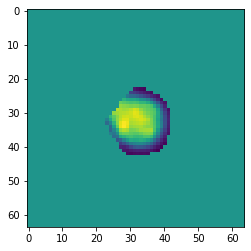

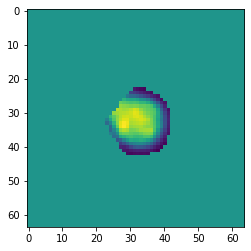

In [12]:
import matplotlib.pyplot as plt

batch = 10
frame = 10
cell = 10

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

train_real_dict = get_real_dict(train_track_info['appearances'])
fig, ax = plt.subplots()
ax.imshow(train_appearances[get_real_idx(batch, frame, cell, train_real_dict)])

# Work on finding cells on boundary and determining frames until split

In [17]:
train_track_info.keys()

dict_keys(['appearances', 'centroids', 'morphologies', 'adj_matrices', 'norm_adj_matrices', 'temporal_adj_matrices'])

In [18]:
type(train_track_info['centroids'])

numpy.ndarray

In [19]:
train_track_info['centroids'].shape

(91, 71, 405, 2)

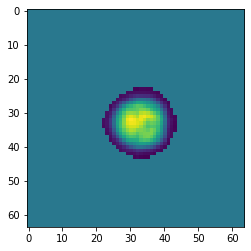

In [98]:
fig, ax = plt.subplots()
ax.imshow(train_appearances[137779])

In [185]:
# centroid path for cell 0 of batch 0
print(train_track_info['centroids'][0, :, 24])
len(train_track_info['centroids'][0, :, 24])

[[  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]
 [579.2517    93.37986 ]
 [575.62695   89.74077 ]
 [569.6305    85.567184]
 [565.2625    85.60745 ]
 [561.08325   84.566025]
 [559.91907   84.06644 ]


71

/tmp/ipykernel_9282/89928243.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


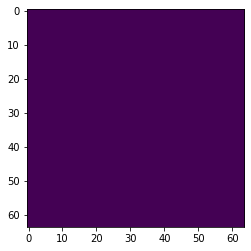

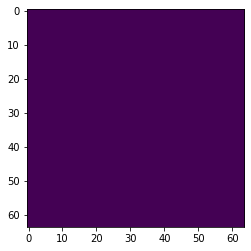

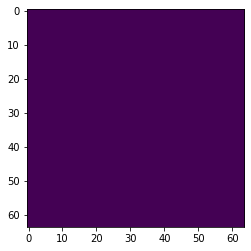

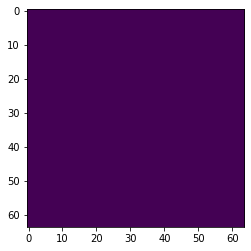

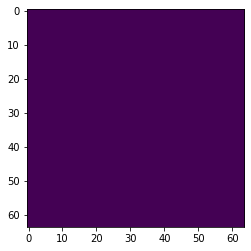

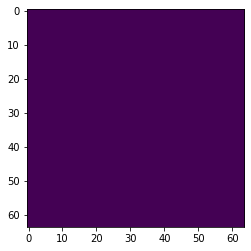

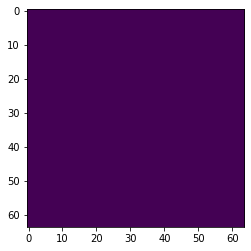

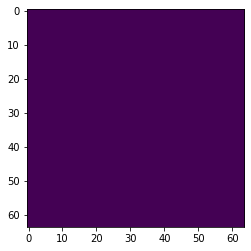

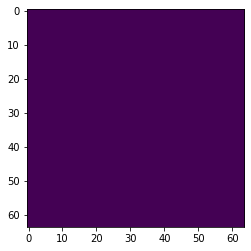

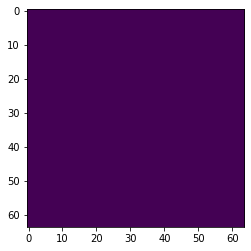

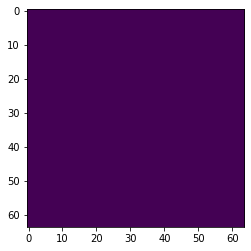

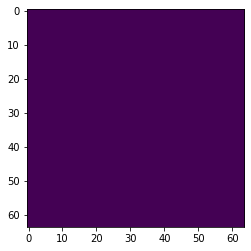

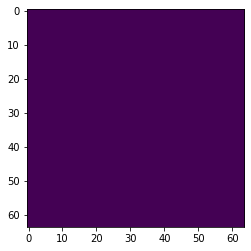

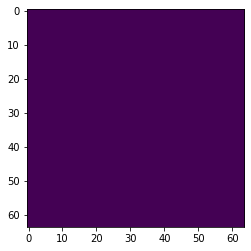

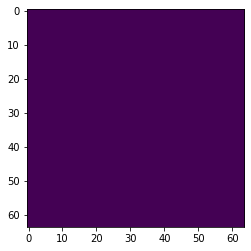

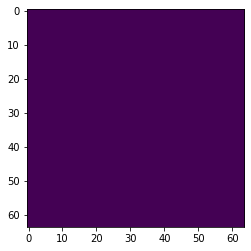

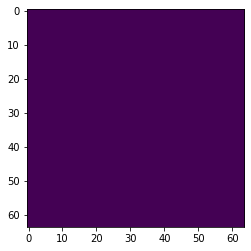

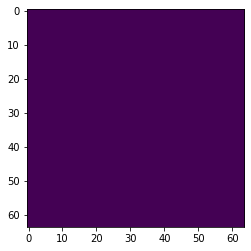

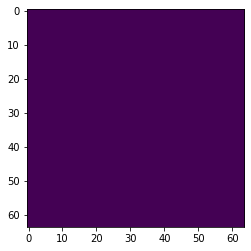

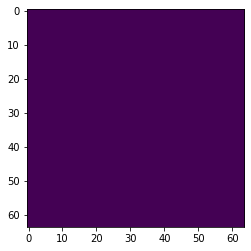

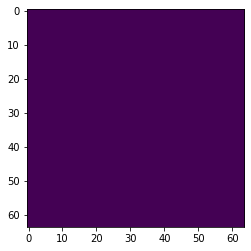

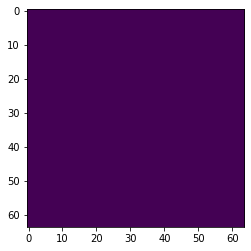

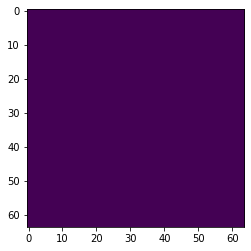

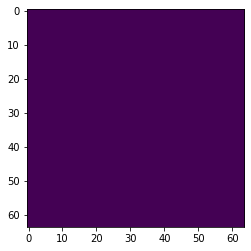

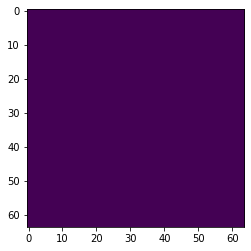

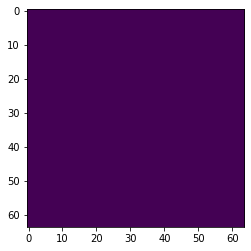

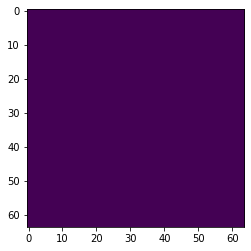

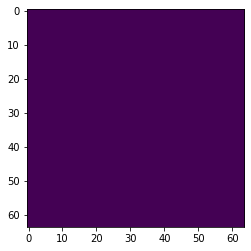

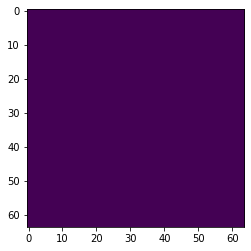

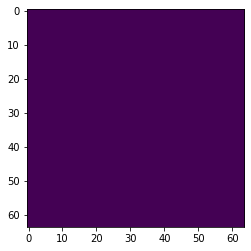

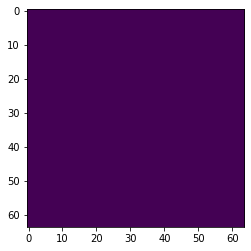

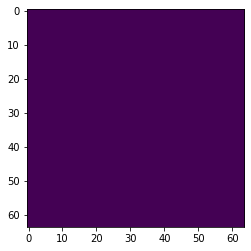

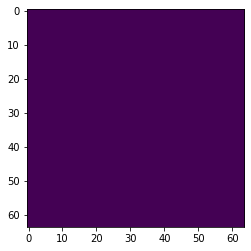

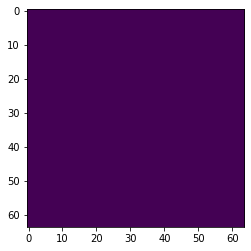

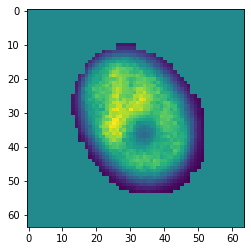

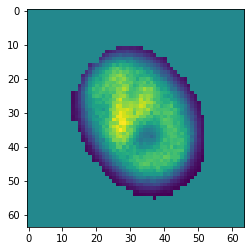

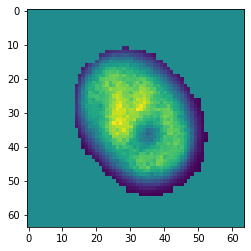

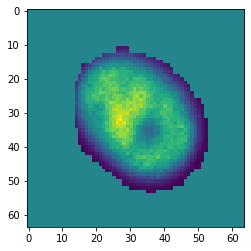

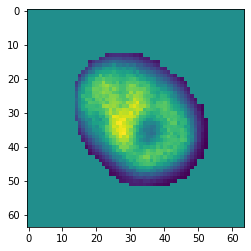

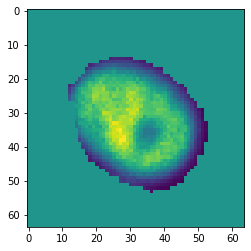

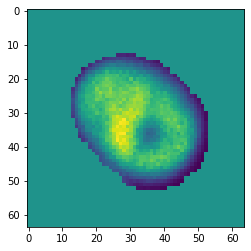

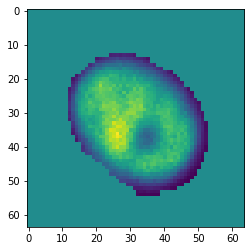

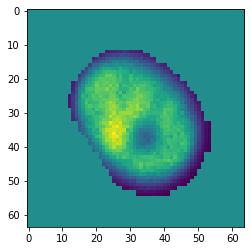

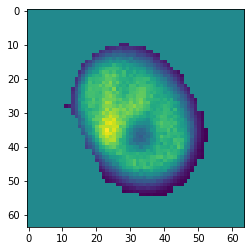

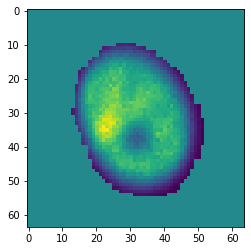

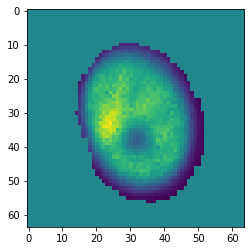

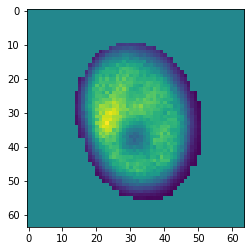

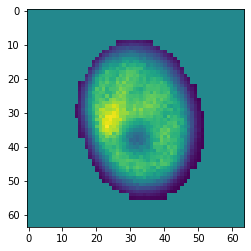

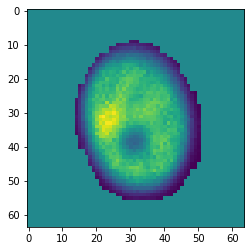

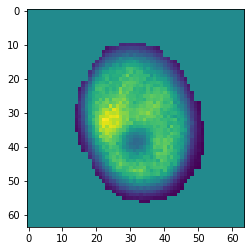

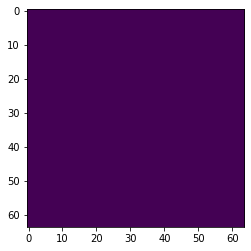

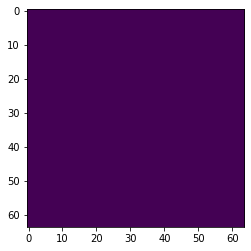

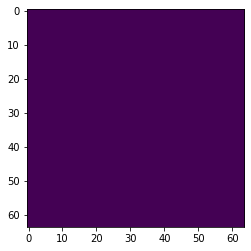

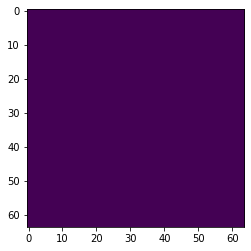

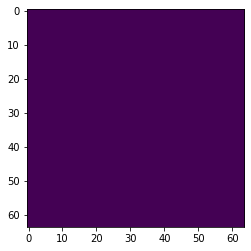

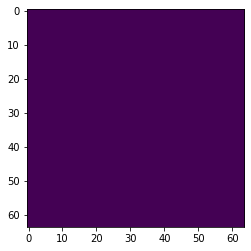

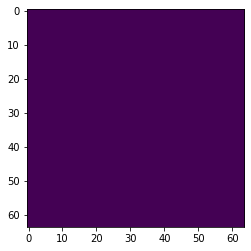

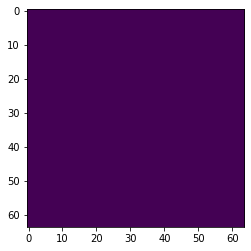

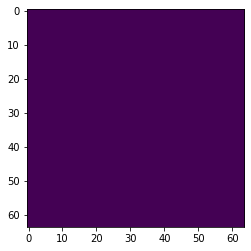

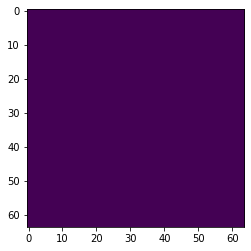

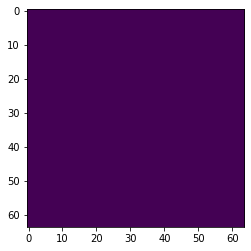

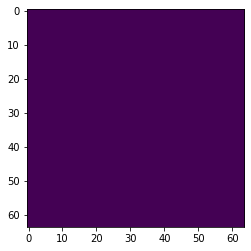

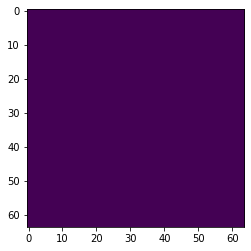

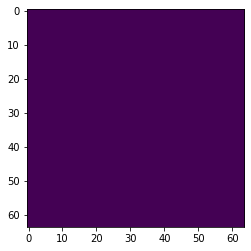

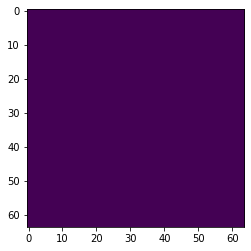

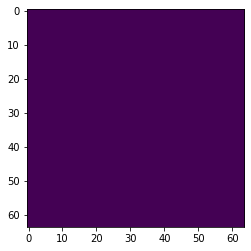

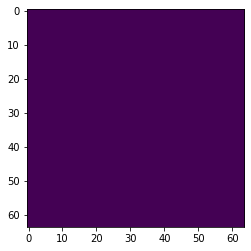

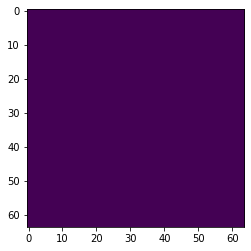

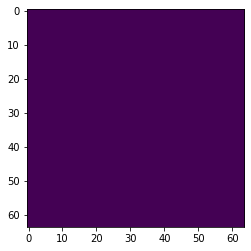

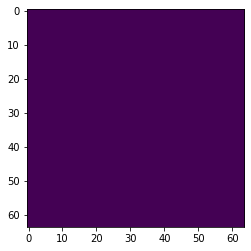

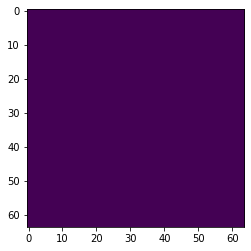

In [116]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][0][i][24])

In [117]:
# # app = track_info['appearances']
# def get_real_dict(app):
#     batches = app.shape[0]
#     frames = app.shape[1]
#     cells = app.shape[2]

#     real_dict = dict.fromkeys(range(batches))
#     for batch in range(batches):
#         real_dict[batch] = {}

#     # Gets number of real cells in each batch
#     for batch in range(batches):
#         for cell in range(cells):
#             if np.max(app[batch, 0, cell]) != 0:
#                 last_frame = 71
#                 for frame in range(frames):
#                     if np.max(app[batch, frame, cell]) == 0:
#                         last_frame = frame
#                         break
#                 real_dict[batch][cell] = last_frame
#             else:
#                 break
#     return real_dict

# def get_real_img_array(app):
#     batches = app.shape[0]
#     frames = app.shape[1]
#     cells = app.shape[2]
    
#     real_img_list = []
#     real_dict = get_real_dict(app)
#     for batch in range(batches):
#         for cell in real_dict[batch].keys():
#             for frame in range(real_dict[batch][cell]):
#                 real_img_list.append(app[batch][frame][cell])
#     appearances = np.array(real_img_list)
#     return appearances

# train_appearances = get_real_img_array(train_track_info['appearances'])



# This is what we have right now. We want to eliminate images on the border as well as ones that don't exist. We will
# now use centroids to do the latter. We also want to update dictionaries simultaneously.

In [122]:
type(all_train_tracks[0].lineages)

list

In [124]:
len(all_train_tracks[0].lineages)

91

In [125]:
len(all_train_tracks[0].lineages[0])

28

In [132]:
len(all_train_tracks[0].lineages[1])

22

In [133]:
len(all_train_tracks[0].lineages[45])

405

In [128]:
all_train_tracks[0].lineages[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [130]:
all_train_tracks[0].lineages[0][1].keys()

dict_keys(['label', 'parent', 'daughters', 'frames'])

In [147]:
all_train_tracks[0].lineages[45][34]['daughters']

[261, 263]

In [188]:
type(all_train_tracks[0].lineages[45][34]['daughters'])

list

In [149]:
all_train_tracks[0].lineages[45][34]['frames']

[0, 1, 2, 3, 4, 5, 6]

In [150]:
all_train_tracks[0].lineages[45][261]['frames']

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70]

In [151]:
all_train_tracks[0].lineages[45][263]['frames']

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70]

In [159]:
all_train_tracks[0].centroids[90, 70, 404]

array([0., 0.], dtype=float32)

In [186]:
all_train_tracks[0].centroids.shape

(91, 71, 405, 2)

In [187]:
train_track_info['appearances'].shape

(91, 71, 405, 64, 64, 1)

In [166]:
arr = np.zeros(2, dtype='float32')
print(arr)
np.array_equal(arr, all_train_tracks[0].centroids[90, 70, 404])

[0. 0.]


True

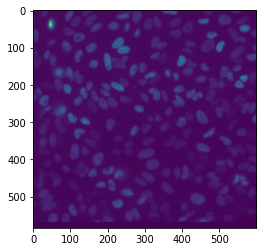

In [171]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].X[45][6])

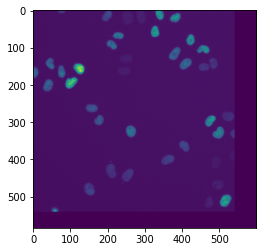

In [172]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].X[90][6])

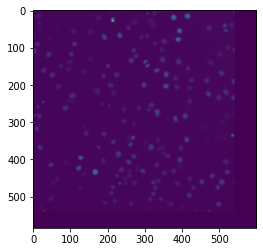

In [173]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].X[10][6])

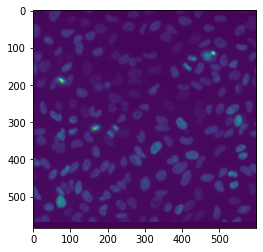

In [174]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].X[50][6])

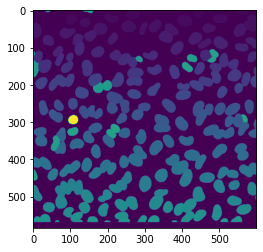

In [175]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].y[50][6])

In [178]:
all_train_tracks[0].y[5][6][0][400]

array([4], dtype=int32)

In [182]:
all_train_tracks[0].y[5][6][0][510]

array([5], dtype=int32)

In [183]:
all_train_tracks[0].y[5][6][300][500]

array([0], dtype=int32)

In [184]:
import copy

In [ ]:
# Need dictionaries (global variables) to store existent vs. blank and on border vs. in middle images

train_good_imgs = {}
train_blank_imgs = {}
train_border_imgs = {}

# We want a function to get the dict of good images, and then another to get the image array

# # app = track_info['appearances']
# def get_real_dict(app):
#     batches = app.shape[0]
#     frames = app.shape[1]
#     cells = app.shape[2]

#     real_dict = dict.fromkeys(range(batches))
#     for batch in range(batches):
#         real_dict[batch] = {}

#     # Gets number of real cells in each batch
#     for batch in range(batches):
#         for cell in range(cells):
#             if np.max(app[batch, 0, cell]) != 0:
#                 last_frame = 71
#                 for frame in range(frames):
#                     if np.max(app[batch, frame, cell]) == 0:
#                         last_frame = frame
#                         break
#                 real_dict[batch][cell] = last_frame
#             else:
#                 break
#     return real_dict

# app = track_info['appearances']
# tracks = all_train_tracks[0]

In [200]:
# Different batches have different borders
def get_borders(tracks, batch_num):
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    for x in range(tracks.X.shape[2]):
        if tracks.X[batch_num][0][x][300] != 0:
            x_min = x - 1
            break
    for x in range(tracks.X.shape[2] - 1, -1, -1):
        if tracks.X[batch_num][0][x][300] != 0:
            x_max = x + 1
            break
    for y in range(tracks.X.shape[3]):
        if tracks.X[batch_num][0][300][y] != 0:
            y_min = y - 1
            break
    for y in range(tracks.X.shape[3] - 1, -1 , -1):
        if tracks.X[batch_num][0][300][y] != 0:
            y_max = y + 1
            break
    return x_min, x_max, y_min, y_max

# all_train_tracks, train_track_info
# tracks = all_train_tracks[0]
# track_info = train_track_info
# We might want to not load "all tracks" and make it a list, eventually, since there is only one track
def det_img_real(tracks, batch, frame, cell):
    cent = tracks.centroids[batch, frame, cell]
    if np.array_equal(cent, np.zeros(2, dtype='float32')):
        return False
    return True
    
# all_train_tracks[0].centroids[90, 70, 404]

# Want to get 'borders' tuple for each batch once
def det_cell_on_border(tracks, batch, frame, cell, borders):
    x_min, x_max, y_min, y_max = borders
    mask_movie_img = tracks.y[batch][frame]
    for x in range(x_min + 1, x_max):
        for width in range(1, 4):
            if mask_movie_img[x][y_min + width] == cell or mask_movie_img[x][y_max - width] == cell:
                return True
    for y in range(y_min + 1, y_max):
        for width in range(1, 4):
            if mask_movie_img[x_min + width][y] == cell or mask_movie_img[x_max - width][y] == cell:
                return True
    return False
    

def get_frames_to_split_dict(tracks):
    batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
    
    frames_to_split_dict = {}
    for batch in range(batches):
        frames_to_split_dict[batch] = {}
        for cell in range(cells):
            frames_to_split_dict[batch][cell] = {}
            for frame in range(frames):
                frames_to_split_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in range(cells):
            if len(all_train_tracks[0].lineages[batch][cell]['daughters']) != 0:
                cell_frames = all_train_tracks[0].lineages[batch][cell]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    frames_to_split_dict[batch][cell][cell_frame] = last_frame - cell_frame + 1
    
    return frames_to_split_dict

def get_good_imgs_dict(tracks):
    # (91, 71, 405, 2)
    batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
    
    good_imgs = {}
    blank_imgs = {}
    border_imgs = {}
    lst_idx_to_pos = {}
    
    for batch in range(batches):
        good_imgs[batch] = {}
        for cell in range(cells):
            good_imgs[batch][cell] = {}
            for frame in range(frames):
                good_imgs[batch][cell][frame] = -1
    blank_imgs = copy.deepcopy(good_imgs)
    border_imgs = copy.deepcopy(good_imgs)
    
    num_good_img = 0
    for batch in range(batches):
        borders = get_borders(tracks, batch)
        for cell in range(cells):
            for frame in range(frames):
                if det_img_real(tracks, batch, frame, cell):
                    if not det_cell_on_border(tracks, batch, frame, cell, borders):
                        good_imgs[batch][cell][frame] = num_good_img
                        lst_idx_to_pos[num_good_img] = (batch, frame, cell)
                        num_good_img += 1
                    else:
                        border_imgs[batch][cell][frame] = 1
                else:
                    blank_imgs[batch][cell][frame] = 1
                
    return good_imgs, blank_imgs, border_imgs, lst_idx_to_pos

# app = track_info['appearances']
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances
# When we eliminate images for being blank or on the border, we might want to add them to a list for later inspection

In [201]:
%%time
train_good_imgs, train_blank_imgs, train_border_imgs, train_lst_idx_to_pos = get_good_imgs_dict(all_train_tracks[0])

CPU times: user 2h 22min 35s, sys: 6.46 s, total: 2h 22min 42s
Wall time: 2h 22min 57s


In [203]:
train_good_imgs[0]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  3

/tmp/ipykernel_9282/1492237082.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


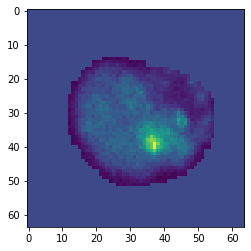

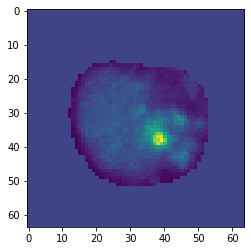

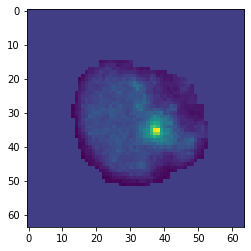

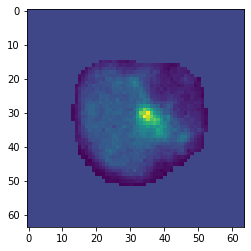

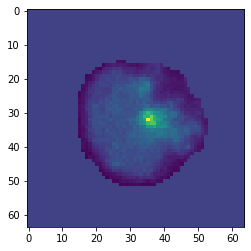

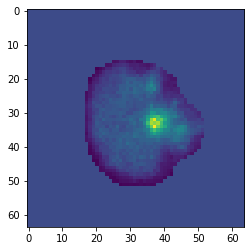

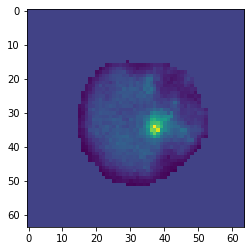

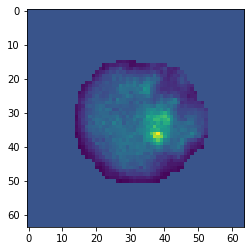

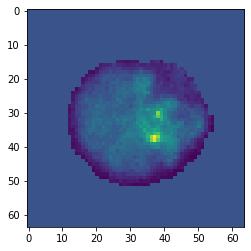

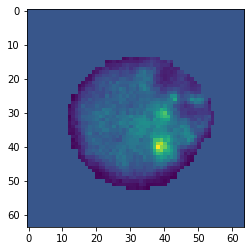

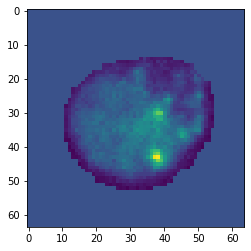

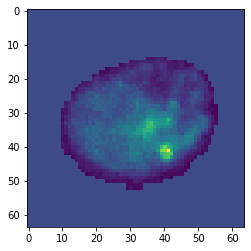

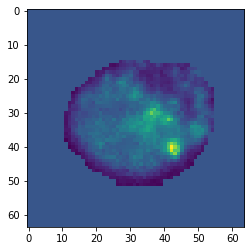

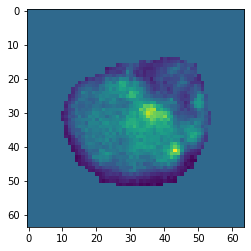

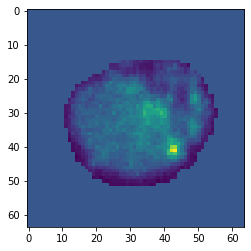

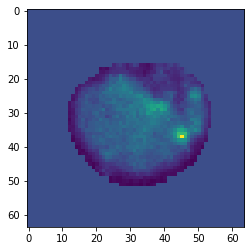

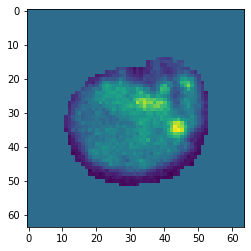

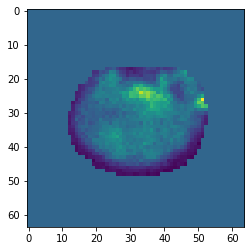

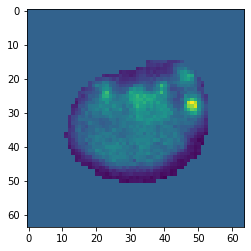

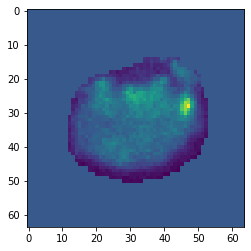

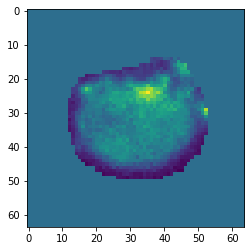

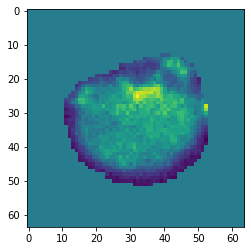

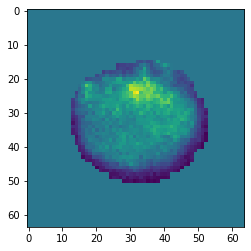

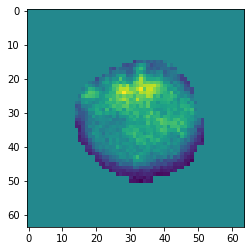

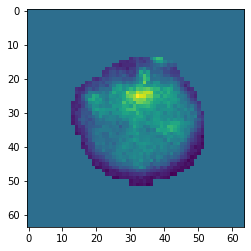

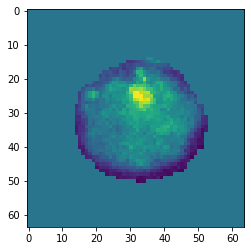

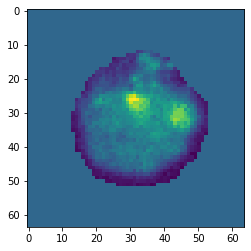

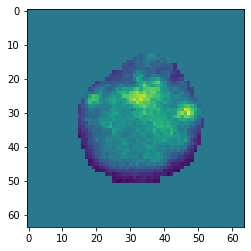

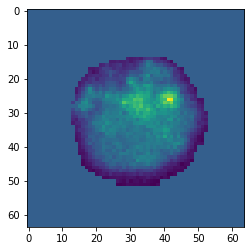

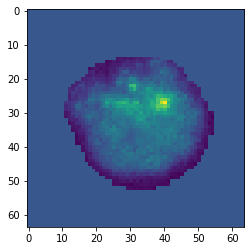

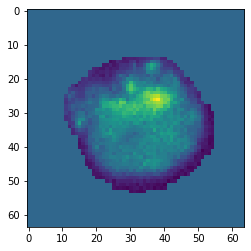

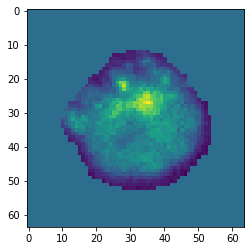

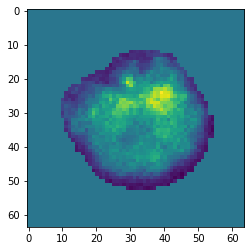

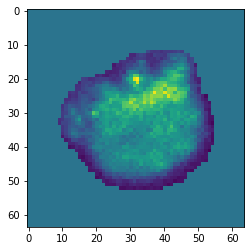

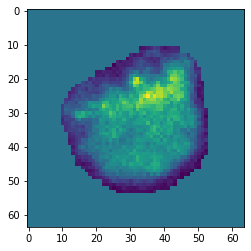

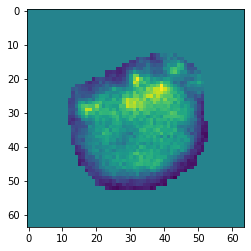

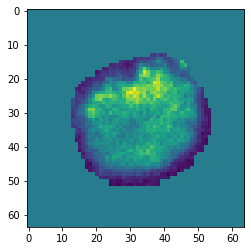

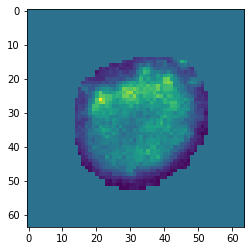

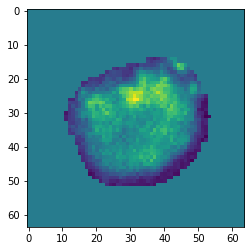

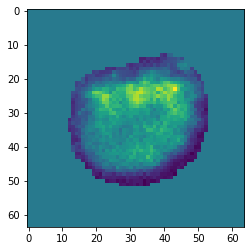

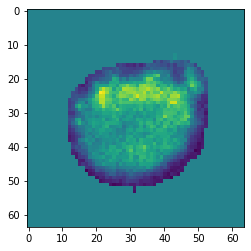

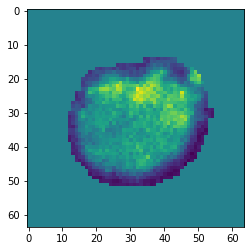

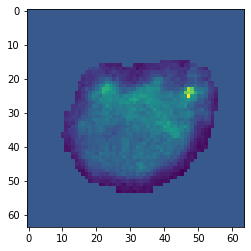

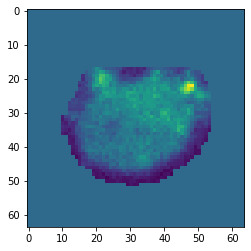

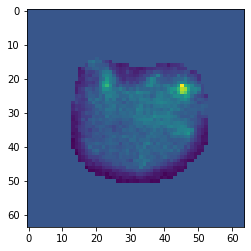

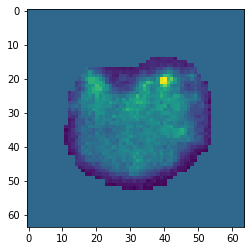

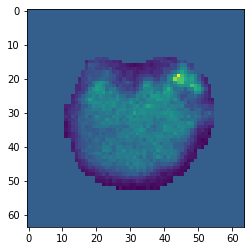

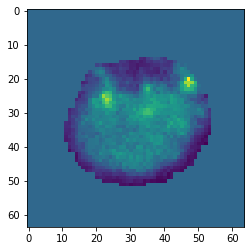

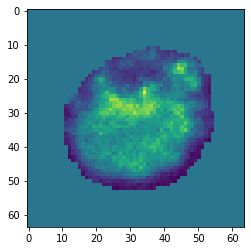

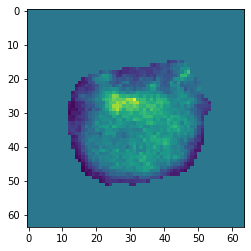

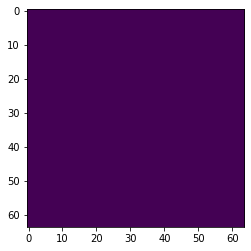

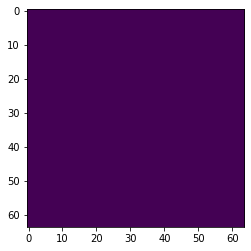

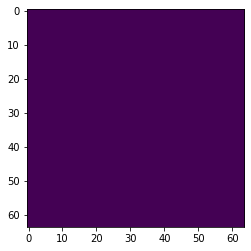

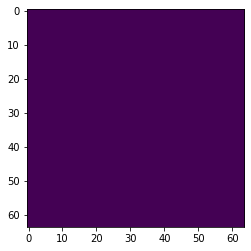

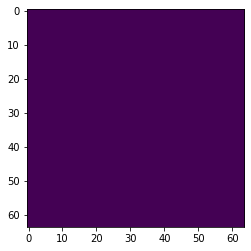

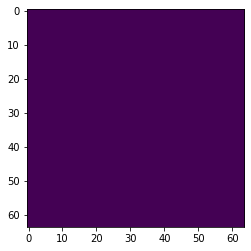

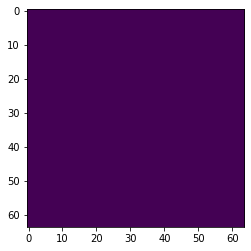

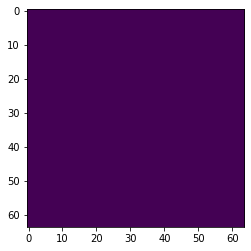

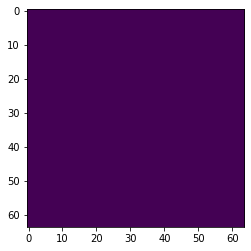

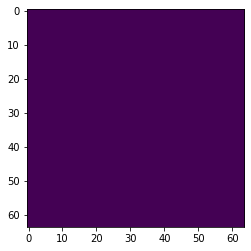

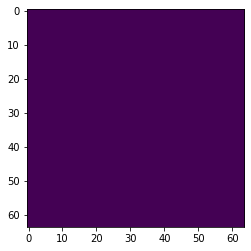

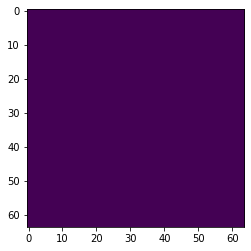

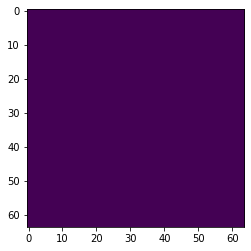

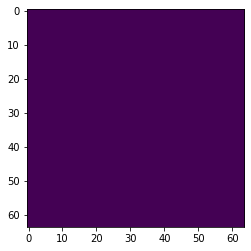

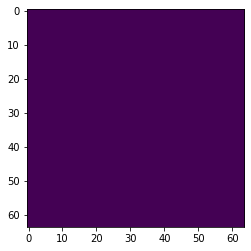

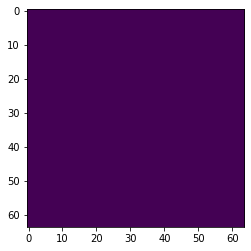

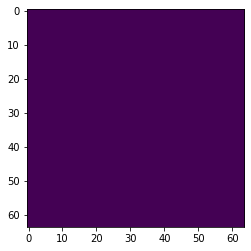

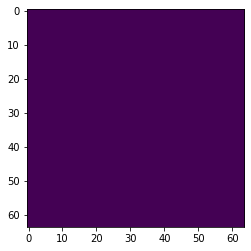

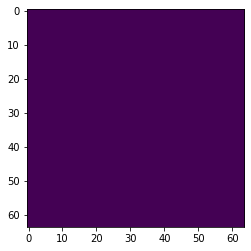

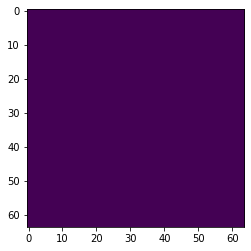

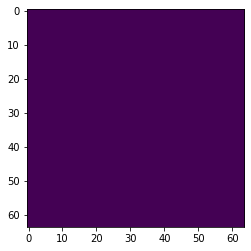

In [210]:
# batch = 10
# frame = 10
# cell = 10

# fig, ax = plt.subplots()
# ax.imshow(train_track_info['appearances'][batch][frame][cell])

# train_real_dict = get_real_dict(train_track_info['appearances'])
# fig, ax = plt.subplots()
# ax.imshow(train_appearances[get_real_idx(batch, frame, cell, train_real_dict)])

for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][0][i][0])

In [211]:
train_track_info['centroids'][0][0][0]

array([152.40154, 297.55615], dtype=float32)

In [212]:
x_min, x_max, y_min, y_max = get_borders(all_train_tracks[0], 0)

In [213]:
print(x_min, x_max, y_min, y_max)

-1 584 -1 584


In [214]:
# Why is it thinking all of the frames of batch 0 cell 0 are not real? (Cell 1 seems fine in the same batch)

/tmp/ipykernel_9282/1679202978.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


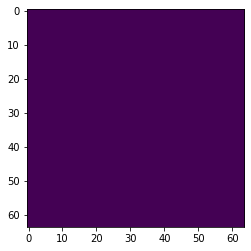

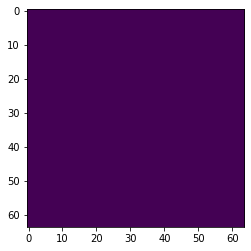

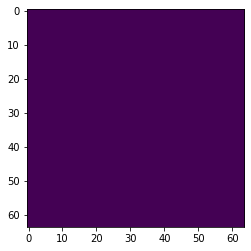

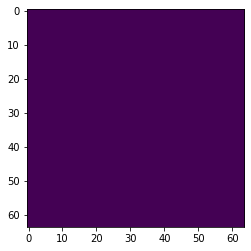

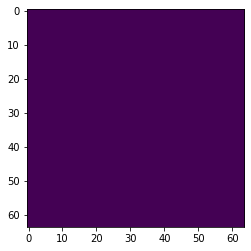

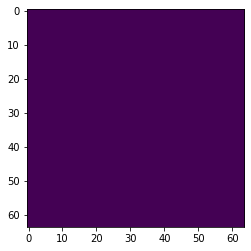

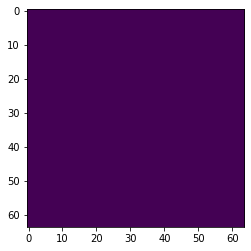

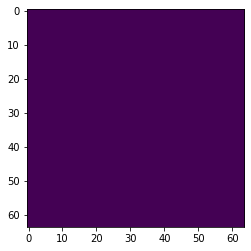

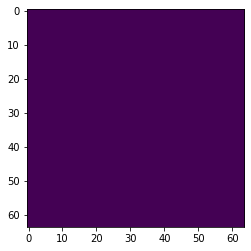

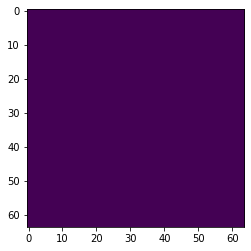

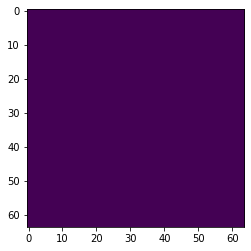

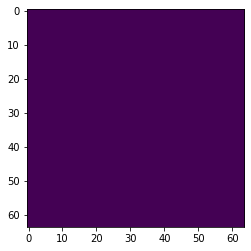

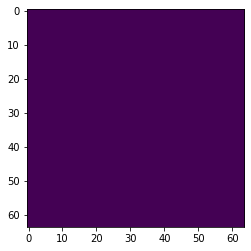

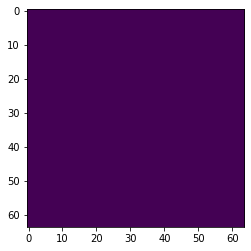

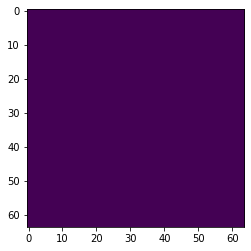

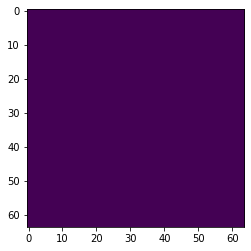

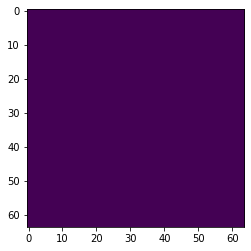

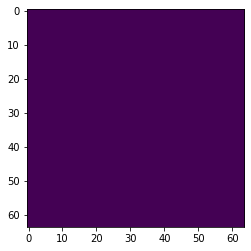

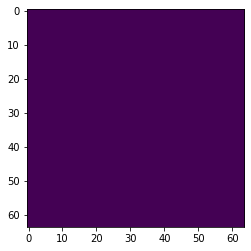

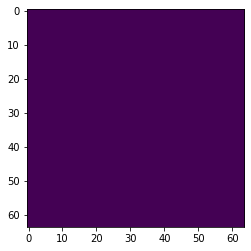

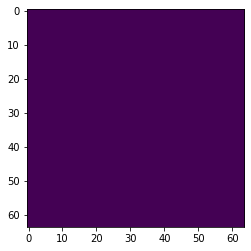

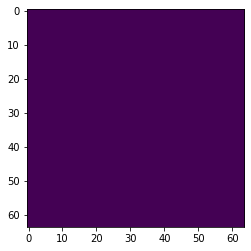

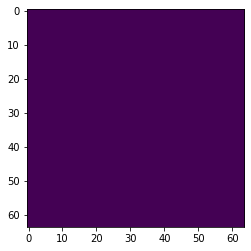

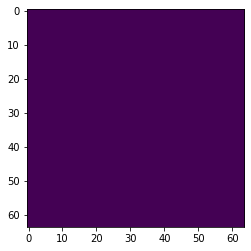

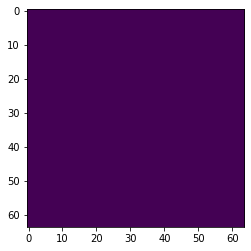

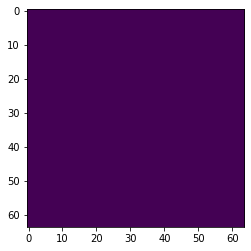

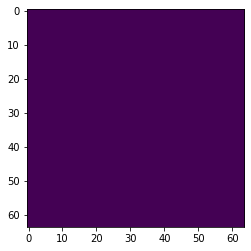

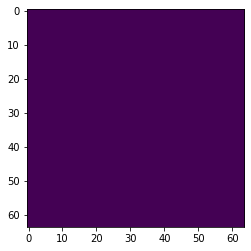

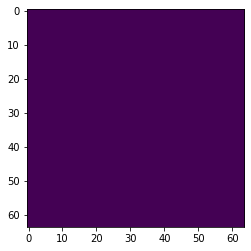

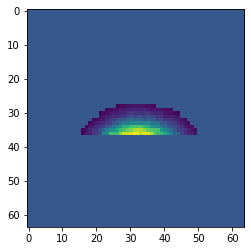

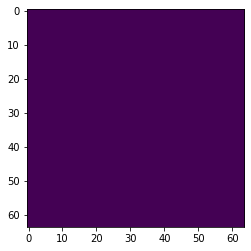

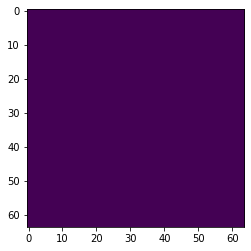

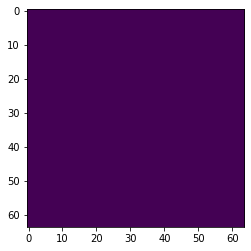

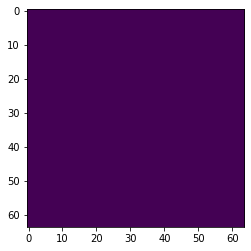

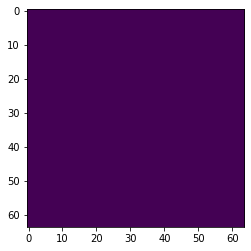

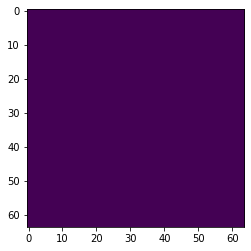

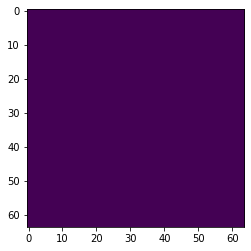

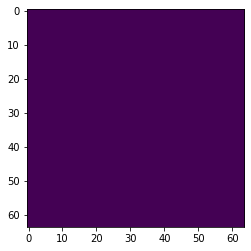

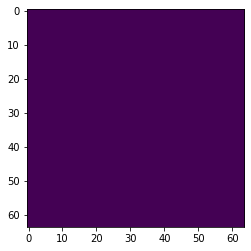

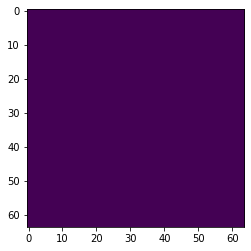

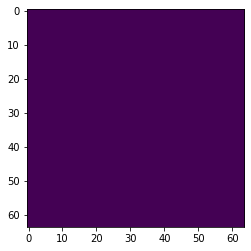

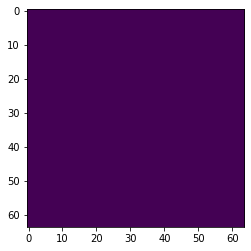

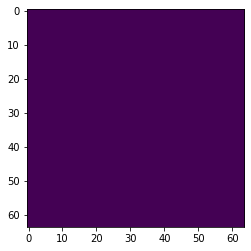

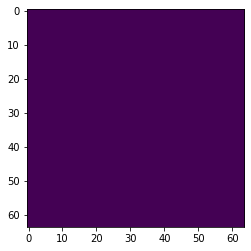

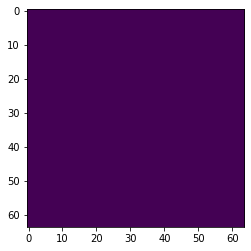

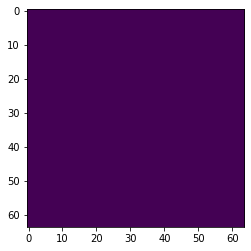

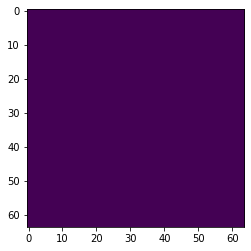

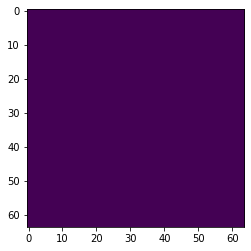

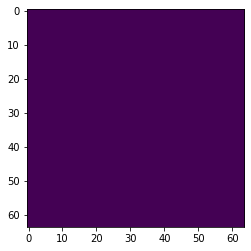

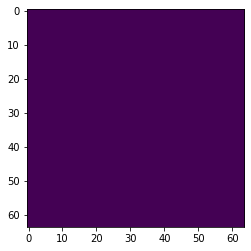

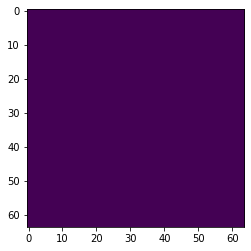

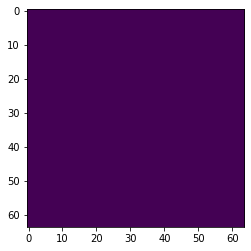

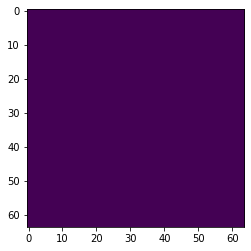

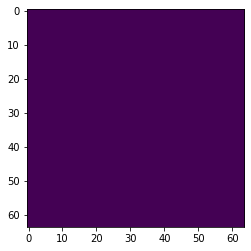

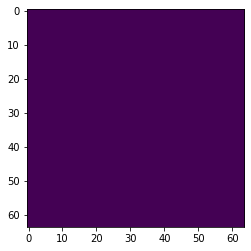

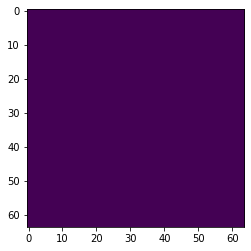

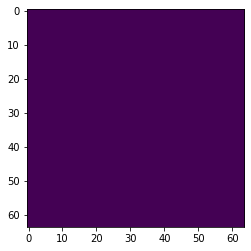

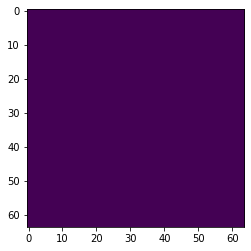

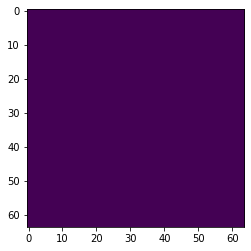

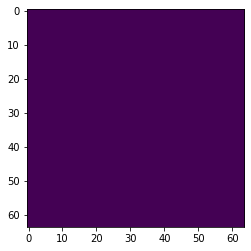

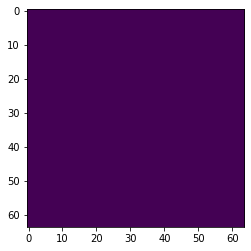

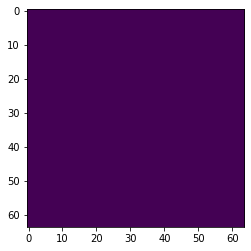

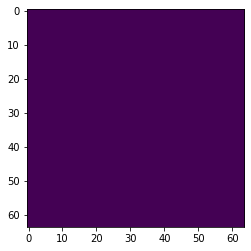

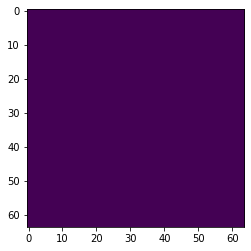

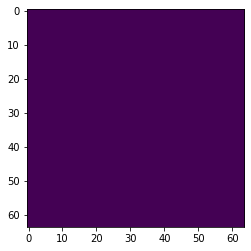

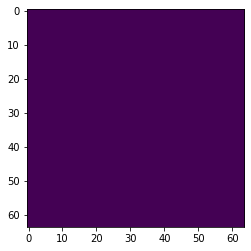

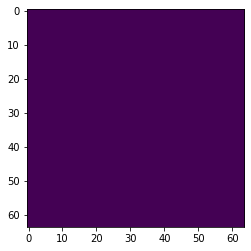

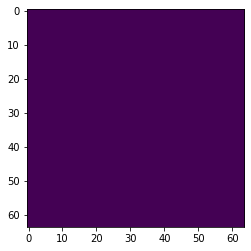

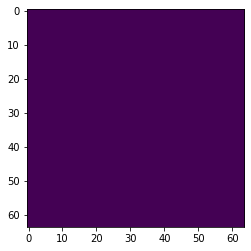

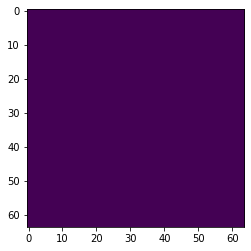

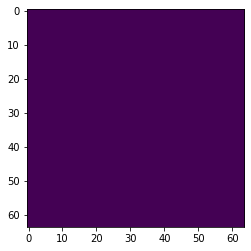

In [215]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][0][i][23])

# All blank except one on the border, reflected in good image dict

/tmp/ipykernel_9282/89928243.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


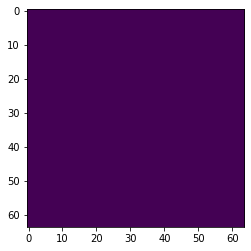

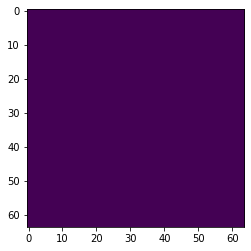

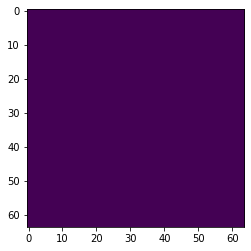

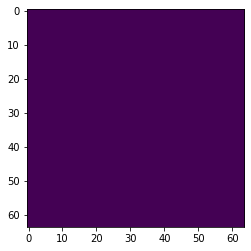

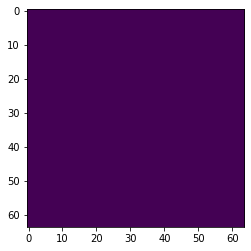

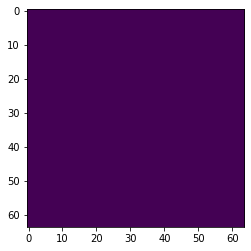

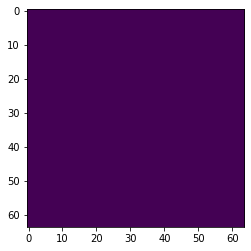

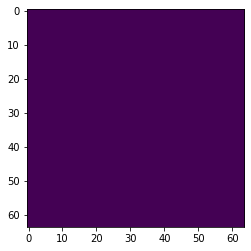

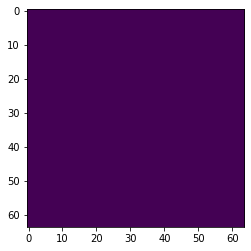

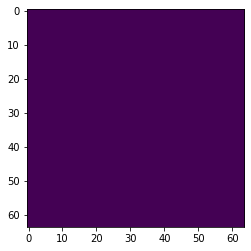

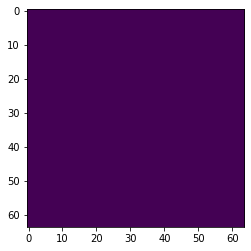

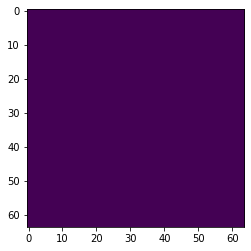

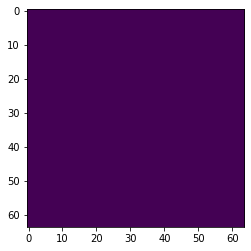

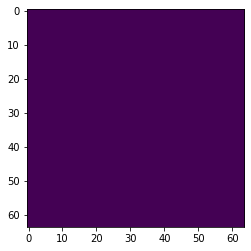

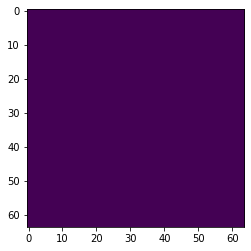

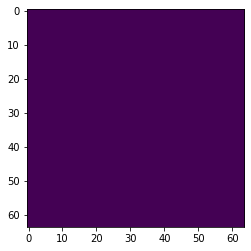

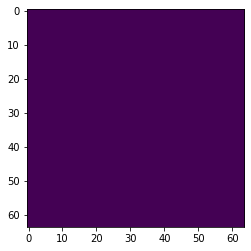

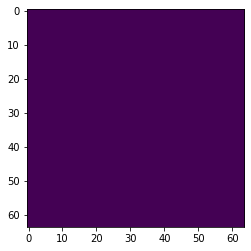

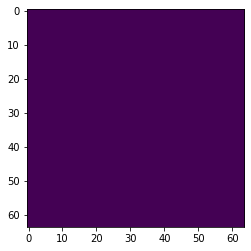

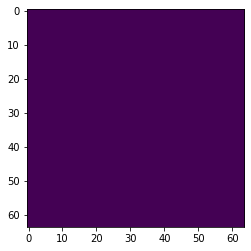

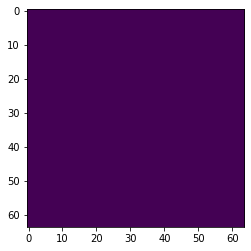

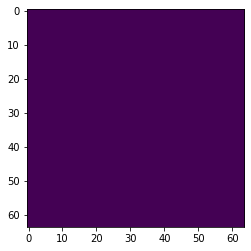

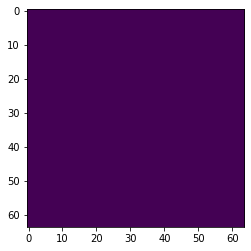

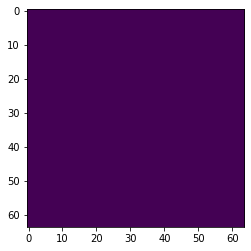

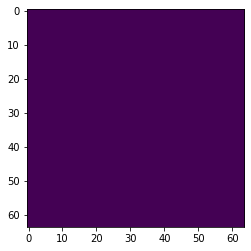

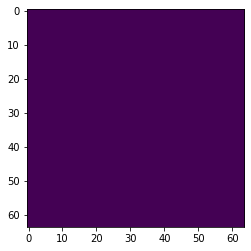

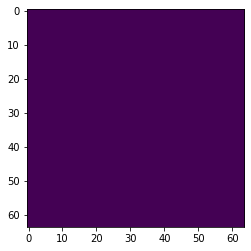

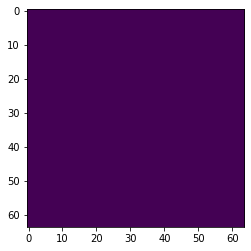

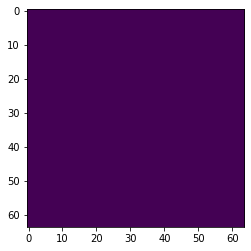

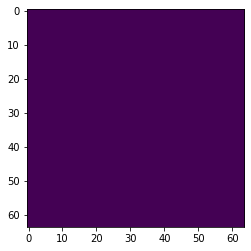

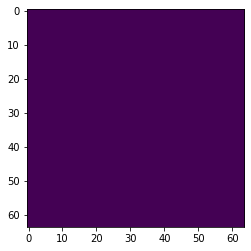

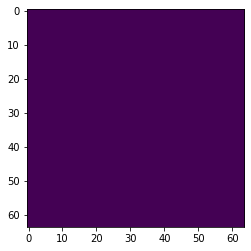

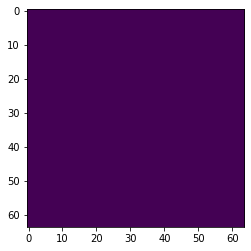

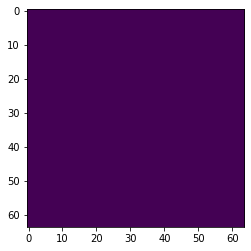

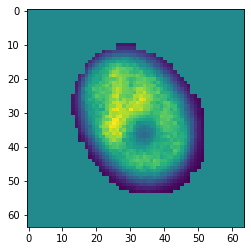

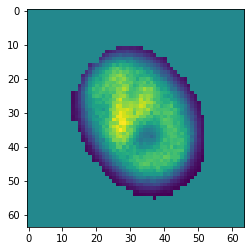

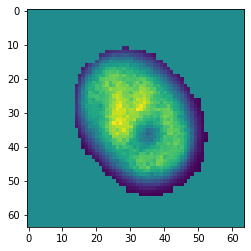

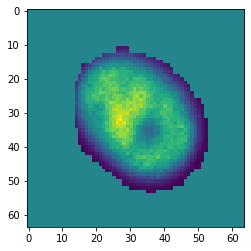

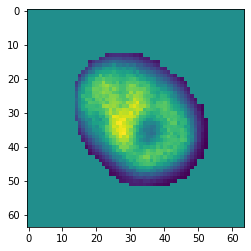

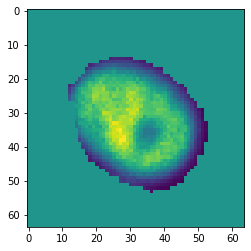

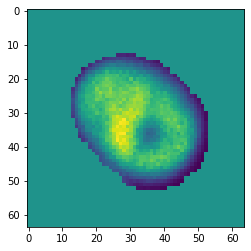

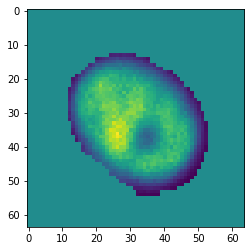

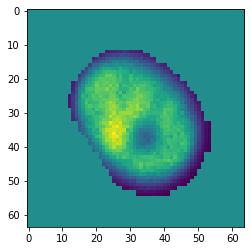

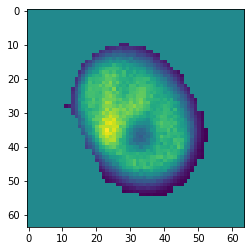

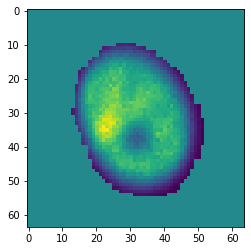

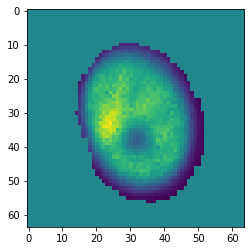

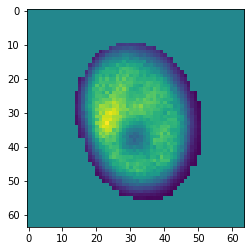

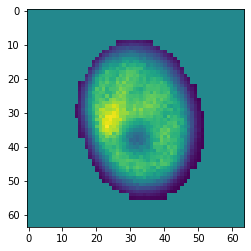

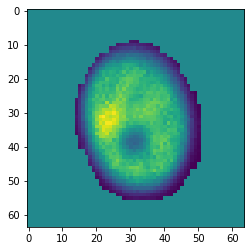

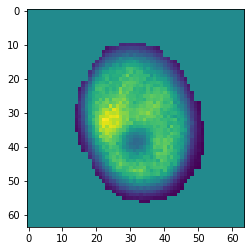

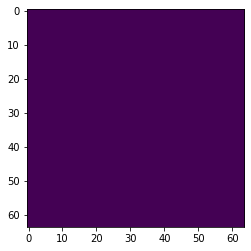

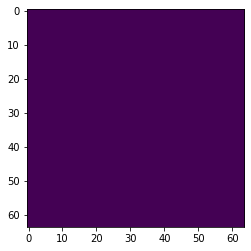

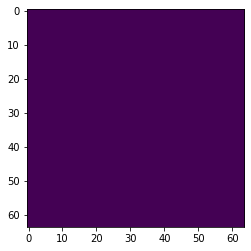

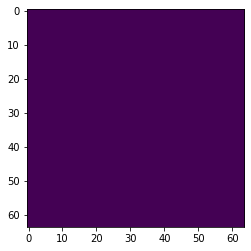

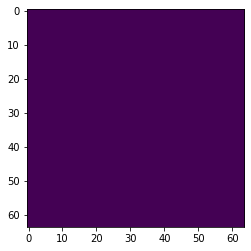

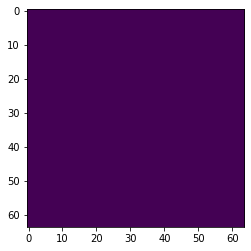

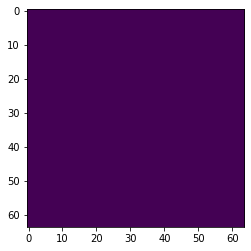

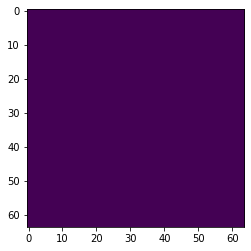

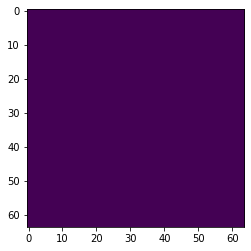

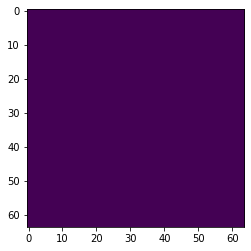

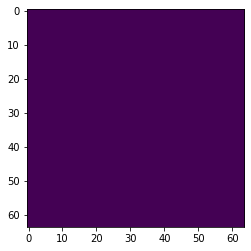

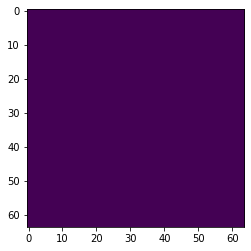

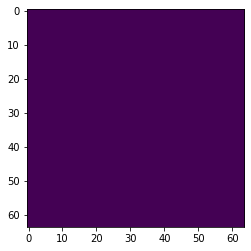

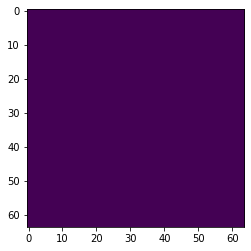

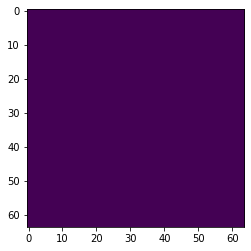

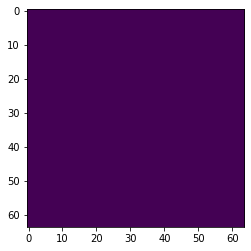

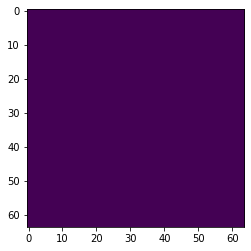

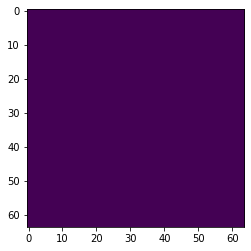

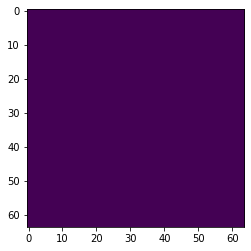

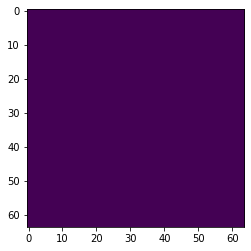

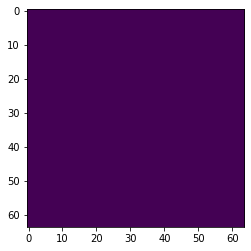

In [219]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][0][i][24])

In [228]:
print(all_train_tracks[0].lineages[0][24]['frames'])

[29]


In [280]:
print(all_train_tracks[0].lineages[0][25]['frames'])

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [282]:
type(all_train_tracks[0].lineages[0])

dict

In [236]:
# batch, frame, cell
all_train_tracks[0].centroids[0, 0, 0]

array([152.40154, 297.55615], dtype=float32)

In [230]:
# batch, frame, cell
det_img_real(all_train_tracks[0], 0, 0, 0)

True

In [231]:
borders = get_borders(all_train_tracks[0], 0)
det_cell_on_border(all_train_tracks[0], 0, 0, 0, borders)

True

In [232]:
print(borders)

(-1, 584, -1, 584)


In [233]:
# Problem because cell 0 has color 0, which is the color of the background. I'm sure the cell colors in y are 1
# greater than the cell number?

In [235]:
# batch, frame, x, y
all_train_tracks[0].y[0][0][152][298]

array([0], dtype=int32)

In [237]:
all_train_tracks[0].centroids[0, 0, 1]

array([184.73775, 137.65074], dtype=float32)

In [239]:
all_train_tracks[0].y[0][0][185][138]

array([0], dtype=int32)

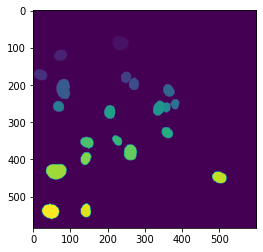

In [240]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].y[0][0])

In [241]:
all_train_tracks[0].y[0][0][50][550]

array([0], dtype=int32)

In [242]:
all_train_tracks[0].y[0][0][550][50]

array([21], dtype=int32)

In [243]:
# x-axis is vertical, y- horizontal

In [244]:
all_train_tracks[0].y[0][0][80][240]

array([1], dtype=int32)

In [245]:
# Try batch 1

In [246]:
train_good_imgs[1]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 923,
  1: 924,
  2: 925,
  3: 926,
  4: 927,
  5: 928,
  6: 929,
  7: 930,
  8: 931,
  9: 932,
  10: 933,
  11: 934,
  12: 935,
  13: 936,
  14: 937,
  15: 938,
  16: 939,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: 940,
  24: 941,
  25: 942,
  26: 943,
  27: 944,
 

In [247]:
# It's still missing cell 0, completely

In [248]:
# batch 1, frame 0, cell 0
all_train_tracks[0].centroids[1, 0, 0]

array([ 97.66913, 331.84933], dtype=float32)

In [249]:
# batch 1, frame 0, cell 1
all_train_tracks[0].centroids[1, 0, 1]

array([174.79634, 630.0824 ], dtype=float32)

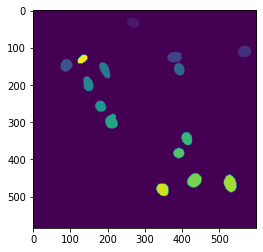

In [250]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].y[1][0])

In [251]:
all_train_tracks[0].y[1][0][98, 332]

array([0], dtype=int32)

In [252]:
all_train_tracks[0].y[1][0][175, 630]

IndexError: index 630 is out of bounds for axis 1 with size 600

/tmp/ipykernel_9282/178241396.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


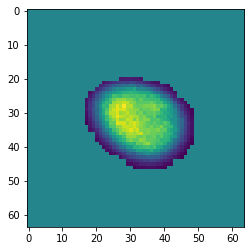

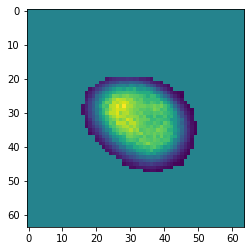

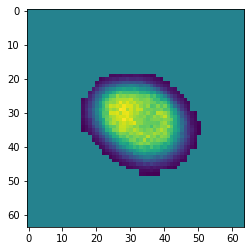

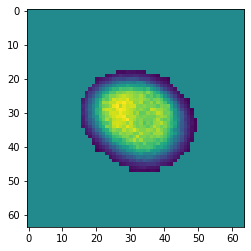

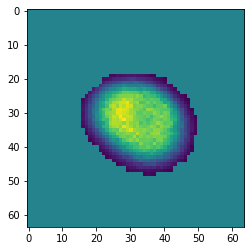

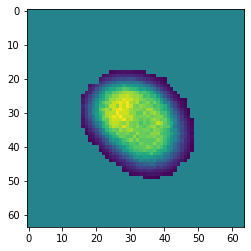

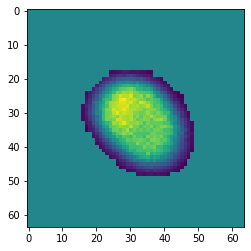

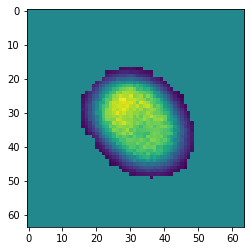

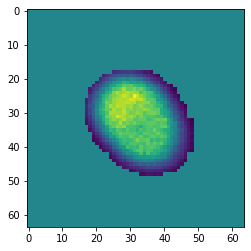

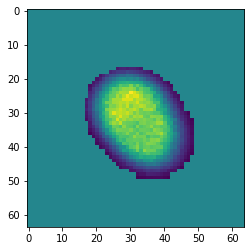

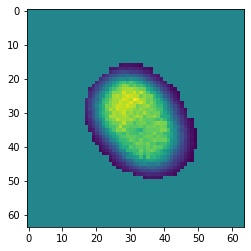

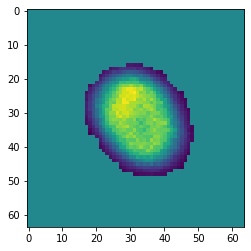

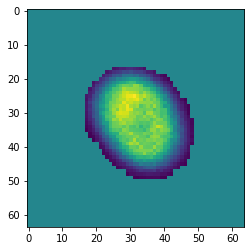

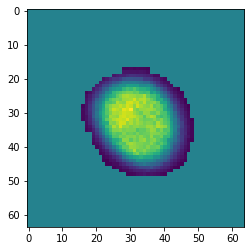

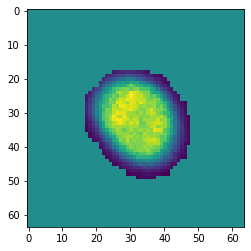

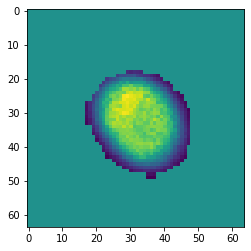

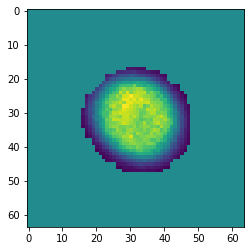

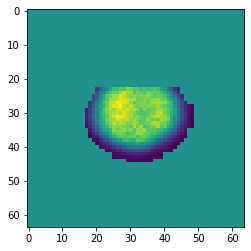

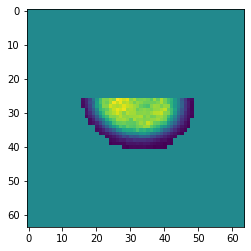

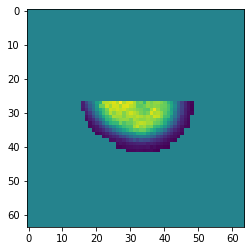

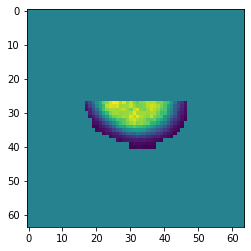

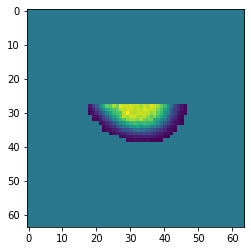

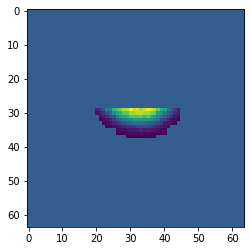

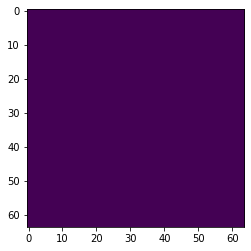

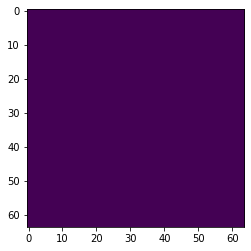

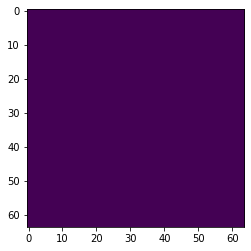

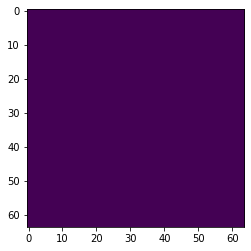

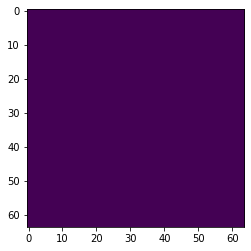

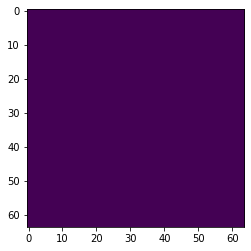

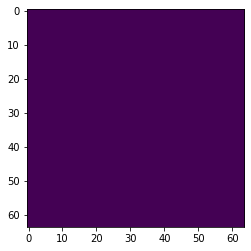

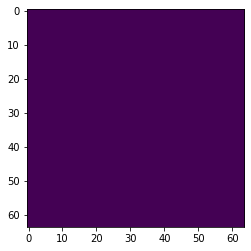

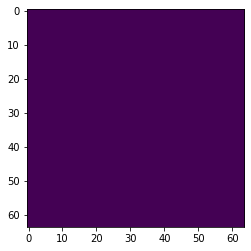

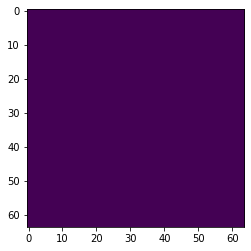

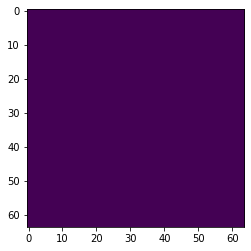

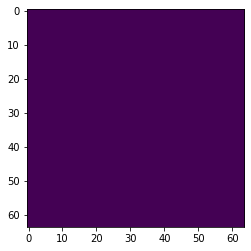

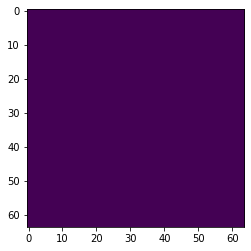

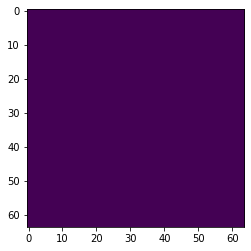

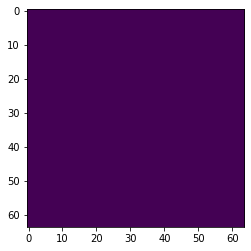

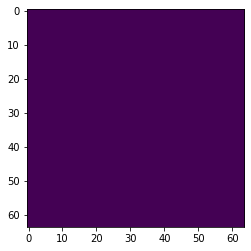

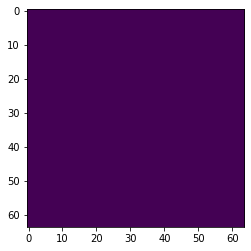

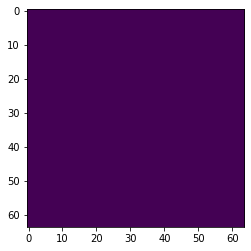

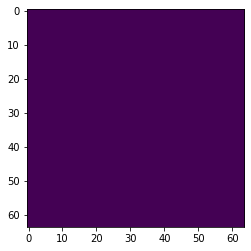

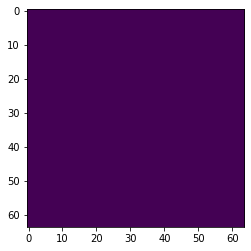

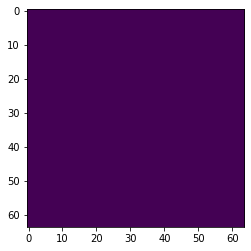

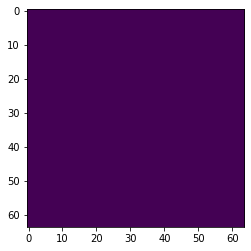

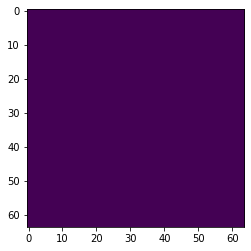

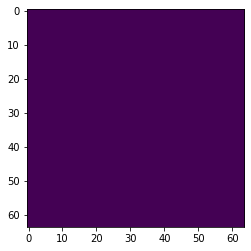

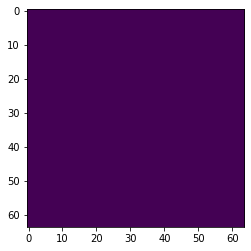

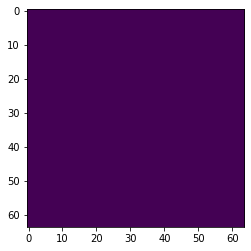

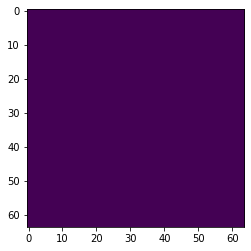

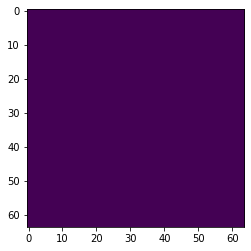

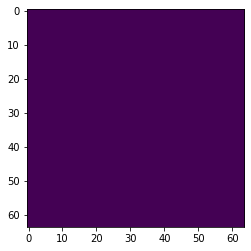

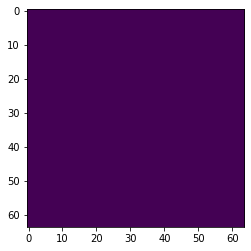

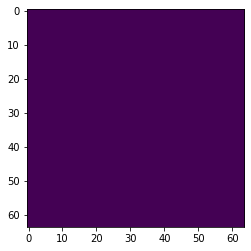

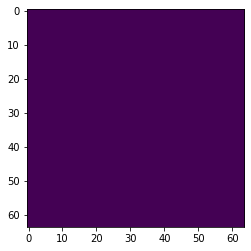

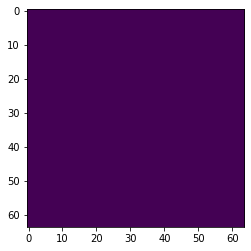

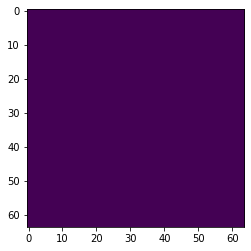

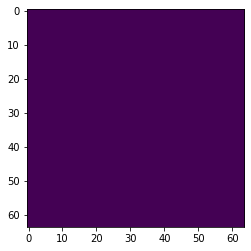

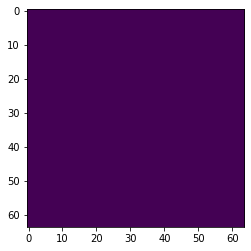

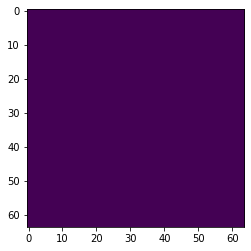

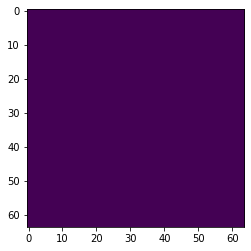

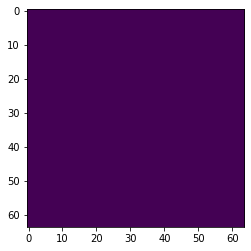

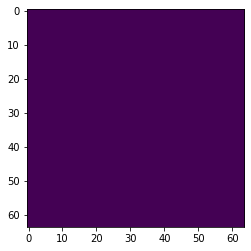

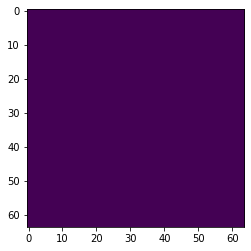

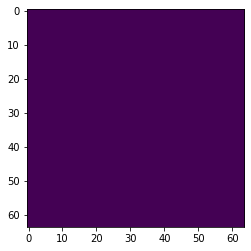

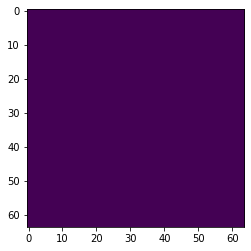

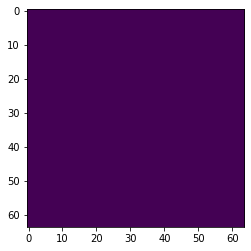

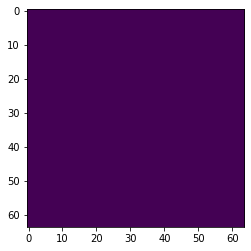

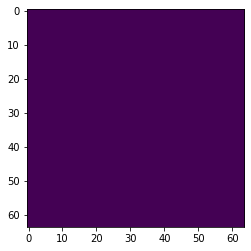

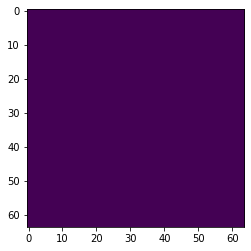

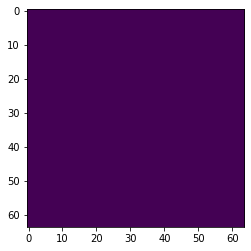

In [253]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][1][i][0])

In [254]:
np.unique(all_train_tracks[0].y[1][0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

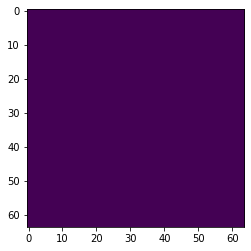

In [255]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][0][15])

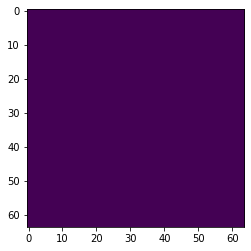

In [256]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][0][16])

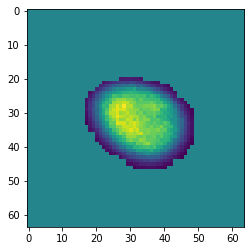

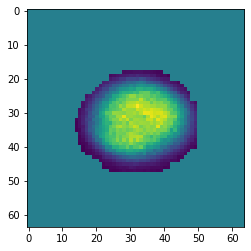

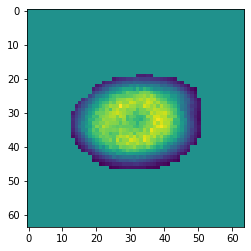

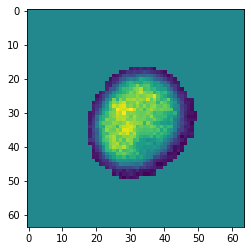

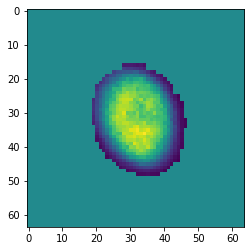

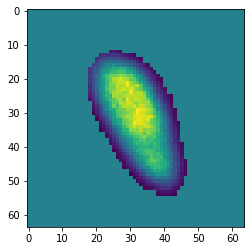

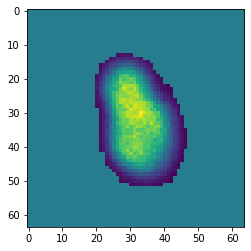

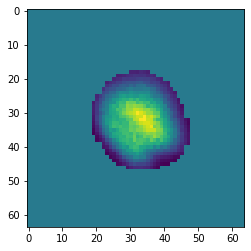

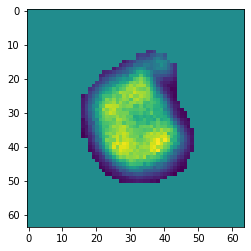

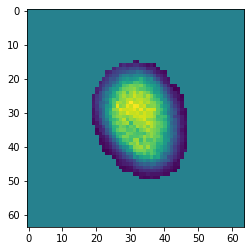

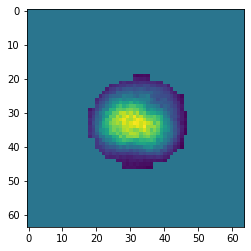

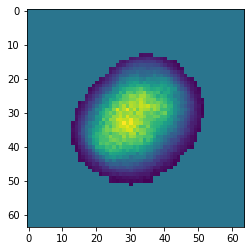

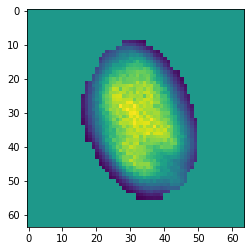

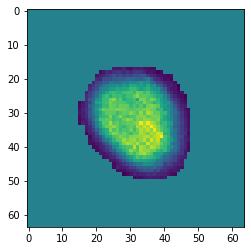

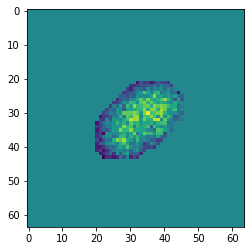

In [258]:
for i in range(15):
    fig, ax = plt.subplots()
    ax.imshow(train_track_info['appearances'][1][0][i])

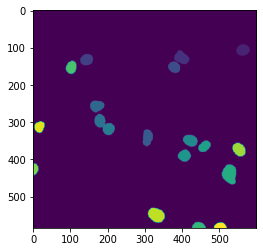

In [259]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].y[1][35])

In [260]:
np.unique(all_train_tracks[0].y[1][35])

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21], dtype=int32)

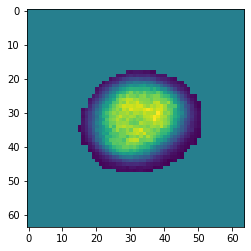

In [261]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][35][1])

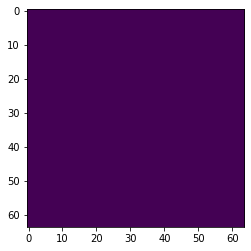

In [262]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][35][0])

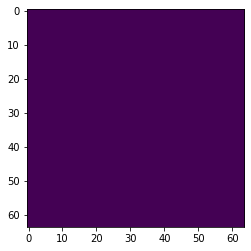

In [263]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][35][15])

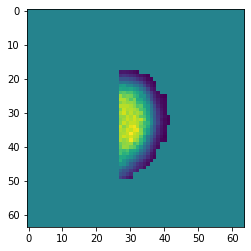

In [264]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][35][16])

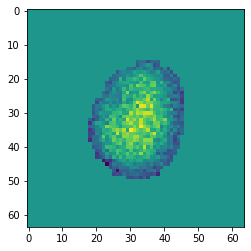

In [265]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][1][35][14])

In [266]:
train_border_imgs[0]

{0: {0: 1,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  27: 1,
  28: 1,
  29: 1,
  30: 1,
  31: 1,
  32: 1,
  33: 1,
  34: 1,
  35: 1,
  36: 1,
  37: 1,
  38: 1,
  39: 1,
  40: 1,
  41: 1,
  42: 1,
  43: 1,
  44: 1,
  45: 1,
  46: 1,
  47: 1,
  48: 1,
  49: 1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  3

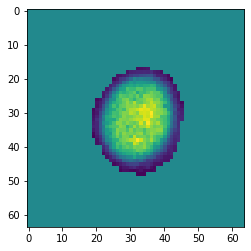

In [267]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][2][3])

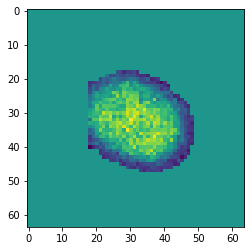

In [270]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][4][2])

In [271]:
# Batch 0 cell 3 was supposed to be on the edge in these frames, but really its cell 2. This supports the idea that
# the labels in the masked image are 1 + cell index

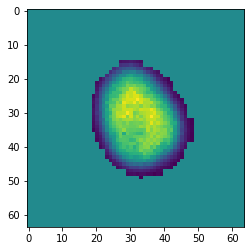

In [272]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][27][6])

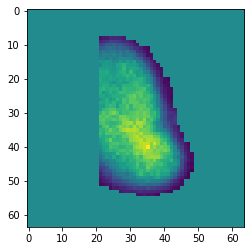

In [273]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][27][5])

In [274]:
# Again

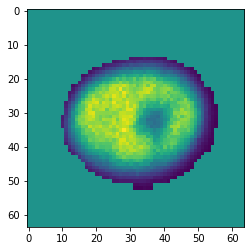

In [275]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][7][20])

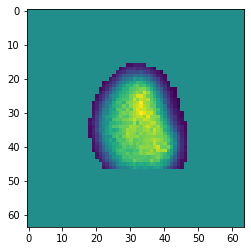

In [276]:
fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][0][7][19])

In [277]:
# And again

In [287]:
# Different batches have different borders
def get_borders(tracks, batch_num):
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    for x in range(tracks.X.shape[2]):
        if tracks.X[batch_num][0][x][300] != 0:
            x_min = x - 1
            break
    for x in range(tracks.X.shape[2] - 1, -1, -1):
        if tracks.X[batch_num][0][x][300] != 0:
            x_max = x + 1
            break
    for y in range(tracks.X.shape[3]):
        if tracks.X[batch_num][0][300][y] != 0:
            y_min = y - 1
            break
    for y in range(tracks.X.shape[3] - 1, -1 , -1):
        if tracks.X[batch_num][0][300][y] != 0:
            y_max = y + 1
            break
    return x_min, x_max, y_min, y_max

# all_train_tracks, train_track_info
# tracks = all_train_tracks[0]
# track_info = train_track_info
# We might want to not load "all tracks" and make it a list, eventually, since there is only one track
def det_img_real(tracks, batch, frame, cell):
    cent = tracks.centroids[batch, frame, cell]
    if np.array_equal(cent, np.zeros(2, dtype='float32')):
        return False
    return True
    
# all_train_tracks[0].centroids[90, 70, 404]

# Want to get 'borders' tuple for each batch once
def det_cell_on_border(tracks, batch, frame, cell, borders):
    x_min, x_max, y_min, y_max = borders
    mask_movie_img = tracks.y[batch][frame]
    color = cell + 1
    for x in range(x_min + 1, x_max):
        for width in range(1, 4):
            if mask_movie_img[x][y_min + width] == color or mask_movie_img[x][y_max - width] == color:
                return True
    for y in range(y_min + 1, y_max):
        for width in range(1, 4):
            if mask_movie_img[x_min + width][y] == color or mask_movie_img[x_max - width][y] == color:
                return True
    return False
    

def get_frames_to_split_dict(tracks):
    batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
    
    frames_to_split_dict = {}
    for batch in range(batches):
        frames_to_split_dict[batch] = {}
        for cell in range(cells):
            frames_to_split_dict[batch][cell] = {}
            for frame in range(frames):
                frames_to_split_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in range(cells):
            cell_label = cell + 1
            if len(all_train_tracks[0].lineages[batch][cell_label]['daughters']) != 0:
                cell_frames = all_train_tracks[0].lineages[batch][cell_label]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    frames_to_split_dict[batch][cell][cell_frame] = last_frame - cell_frame + 1
    
    return frames_to_split_dict

def get_good_imgs_dict(tracks):
    # (91, 71, 405, 2)
    batches, frames, cells = tracks.centroids.shape[:3]
    
    good_imgs = {}
    blank_imgs = {}
    border_imgs = {}
    lst_idx_to_pos = {}
    
    for batch in range(batches):
        good_imgs[batch] = {}
        for cell in range(cells):
            good_imgs[batch][cell] = {}
            for frame in range(frames):
                good_imgs[batch][cell][frame] = -1
    blank_imgs = copy.deepcopy(good_imgs)
    border_imgs = copy.deepcopy(good_imgs)
    
    num_good_img = 0
    for batch in range(batches):
        borders = get_borders(tracks, batch)
        for cell in range(cells):
            for frame in range(frames):
                if det_img_real(tracks, batch, frame, cell):
                    if not det_cell_on_border(tracks, batch, frame, cell, borders):
                        good_imgs[batch][cell][frame] = num_good_img
                        lst_idx_to_pos[num_good_img] = (batch, frame, cell)
                        num_good_img += 1
                    else:
                        border_imgs[batch][cell][frame] = 1
                else:
                    blank_imgs[batch][cell][frame] = 1
                
    return good_imgs, blank_imgs, border_imgs, lst_idx_to_pos

# app = track_info['appearances']
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances
# When we eliminate images for being blank or on the border, we might want to add them to a list for later inspection

In [288]:
%%time
train_good_imgs, train_blank_imgs, train_border_imgs, train_lst_idx_to_pos = get_good_imgs_dict(all_train_tracks[0])

CPU times: user 2h 22min 10s, sys: 2.47 s, total: 2h 22min 12s
Wall time: 2h 22min 9s


In [283]:
type(all_train_tracks[0].centroids)

numpy.ndarray

In [284]:
type(all_train_tracks[0].centroids[0])

numpy.ndarray

In [285]:
type(all_train_tracks[0].centroids[0][0])

numpy.ndarray

In [286]:
type(all_train_tracks[0].centroids[0][0][0])

numpy.ndarray

In [289]:
train_good_imgs[0]

{0: {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 50,
  1: 51,
  2: 52,
  3: 53,
  4: 54,
  5: 55,
  6: 56,
  7: 57,
  8: 58,
  9: 59,
  10: 60,
  11: 61,
  12: 62,
  13: 63,
  14: 64,
  15: 65,
  16: 66,
  17: 67,
  18: 68,
  19: 69,
  20: 70,
  21: 71,
  22: 72,
  23: 73,
  24: 74,
  25: 75,
  26: 76,
  27: 77,
  28: 78,
  29: 79,
  30: 80,
  3

In [290]:
train_border_imgs[0]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  3

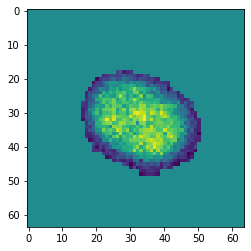

In [291]:
batch = 0
frame = 2
cell = 2

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

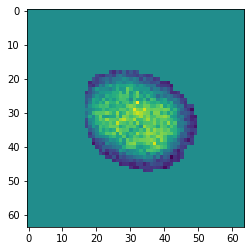

In [292]:
batch = 0
frame = 3
cell = 2

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

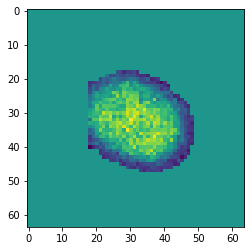

In [293]:
batch = 0
frame = 4
cell = 2

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

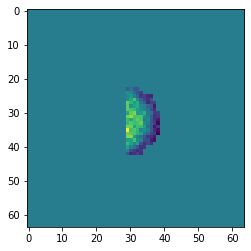

In [297]:
batch = 0
frame = 11
cell = 2

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

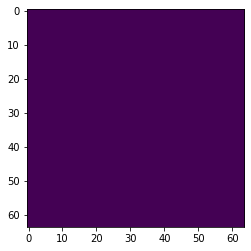

In [298]:
batch = 0
frame = 12
cell = 2

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

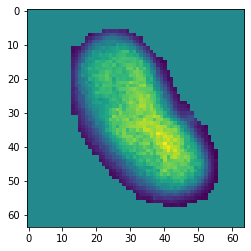

In [299]:
batch = 0
frame = 25
cell = 5

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

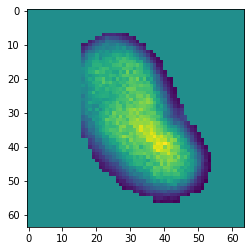

In [300]:
batch = 0
frame = 26
cell = 5

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

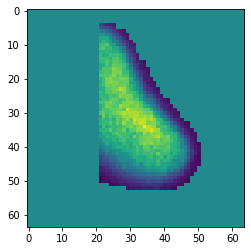

In [301]:
batch = 0
frame = 39
cell = 5

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

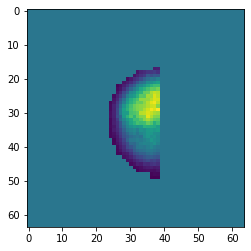

In [302]:
batch = 0
frame = 42
cell = 7

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

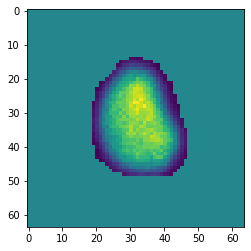

In [304]:
batch = 0
frame = 6
cell = 19

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

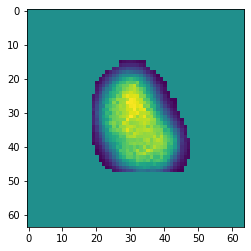

In [305]:
batch = 0
frame = 9
cell = 19

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

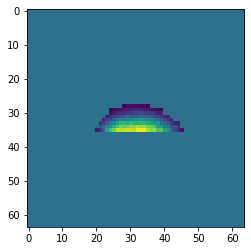

In [314]:
batch = 0
frame = 23
cell = 22

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

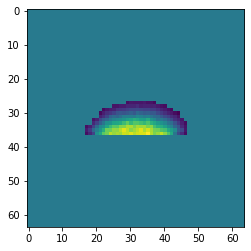

In [313]:
batch = 0
frame = 27
cell = 22

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

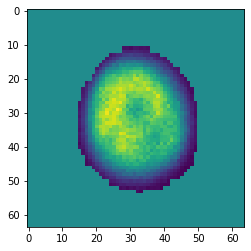

In [316]:
batch = 0
frame = 37
cell = 22

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

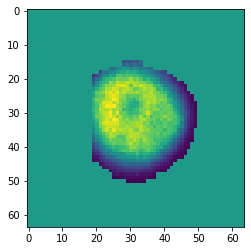

In [317]:
batch = 0
frame = 39
cell = 22

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

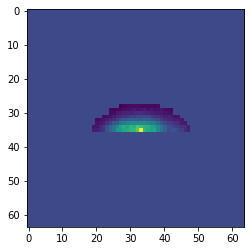

In [318]:
batch = 0
frame = 31
cell = 27

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

In [321]:
# train_good_imgs, train_blank_imgs, train_border_imgs, train_lst_idx_to_pos
batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
for batch in range(batches):
    print(batch)
    for frame in range(frames):
        for cell in range(cells):
            if train_good_imgs[batch][cell][frame] != -1:
                if np.max(train_track_info['appearances'][batch][frame][cell]) == 0:
                    print('Oops--good image is blank: ' + str(frame) + ' ' + str(cell))
            elif train_border_imgs[batch][cell][frame] != -1:
                if np.max(train_track_info['appearances'][batch][frame][cell]) == 0:
                    print('Oops--border image is blank: ' + str(frame) + ' ' + str(cell))
            else:
                if np.max(train_track_info['appearances'][batch][frame][cell]) != 0:
                    print('Oops--blank image is not blank: ' + str(frame) + ' ' + str(cell))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Oops--border image is blank: 44 8
31
Oops--good image is blank: 41 198
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


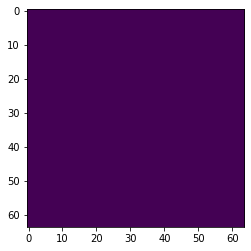

In [322]:
batch = 30
frame = 44
cell = 8

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

In [323]:
all_train_tracks[0].centroids[batch][frame][cell]

array([174.06888, 158.48724], dtype=float32)

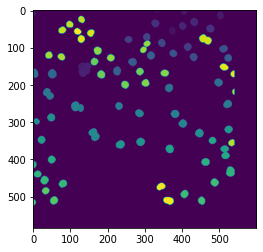

In [325]:
fig, ax = plt.subplots()
ax.imshow(all_train_tracks[0].y[batch][frame])

In [330]:
all_train_tracks[0].y[batch][frame][170, 180]

array([86], dtype=int32)

In [331]:
det_cell_on_border(all_train_tracks[0], batch, frame, cell, get_borders(all_train_tracks[0], batch))

True

In [332]:
# Weird. The centroid is clearly not on the edge, but apparently the cell is on the edge. And the single-cell image
# itself is blank. Hm.

In [333]:
%%time
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    
    all_val_tracks = [Track(tracked_data=d, crop_mode='fixed') for d in all_val_data]
    
    val_track_info = concat_tracks(all_val_tracks)
    
    val_appearances = get_real_img_array(val_track_info['appearances'])
    
    val_dataset = prepare_dataset(val_appearances, batch_size=100)

100%|███████████████████████████████████████████| 27/27 [02:19<00:00,  5.18s/it]
2022-07-30 03:03:35.313435: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1060745520 exceeds 10% of free system memory.


CPU times: user 21min 30s, sys: 22min 47s, total: 44min 18s
Wall time: 7min 58s


In [340]:
# Different batches have different borders
def get_borders(tracks, batch_num):
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    for x in range(tracks.X.shape[2]):
        if tracks.X[batch_num][0][x][300] != 0:
            x_min = x - 1
            break
    for x in range(tracks.X.shape[2] - 1, -1, -1):
        if tracks.X[batch_num][0][x][300] != 0:
            x_max = x + 1
            break
    for y in range(tracks.X.shape[3]):
        if tracks.X[batch_num][0][300][y] != 0:
            y_min = y - 1
            break
    for y in range(tracks.X.shape[3] - 1, -1 , -1):
        if tracks.X[batch_num][0][300][y] != 0:
            y_max = y + 1
            break
    return x_min, x_max, y_min, y_max

# all_train_tracks, train_track_info
# tracks = all_train_tracks[0]
# track_info = train_track_info
# We might want to not load "all tracks" and make it a list, eventually, since there is only one track
def det_img_real(tracks, batch, frame, cell):
    cent = tracks.centroids[batch, frame, cell]
    if np.array_equal(cent, np.zeros(2, dtype='float32')):
        return False
    return True
    
# all_train_tracks[0].centroids[90, 70, 404]

# Want to get 'borders' tuple for each batch once
def det_cell_on_border(tracks, batch, frame, cell, borders):
    x_min, x_max, y_min, y_max = borders
    mask_movie_img = tracks.y[batch][frame]
    color = cell + 1
    for x in range(x_min + 1, x_max):
        for width in range(1, 4):
            if mask_movie_img[x][y_min + width] == color or mask_movie_img[x][y_max - width] == color:
                return True
    for y in range(y_min + 1, y_max):
        for width in range(1, 4):
            if mask_movie_img[x_min + width][y] == color or mask_movie_img[x_max - width][y] == color:
                return True
    return False
    

def get_frames_to_split_dict(tracks):
    batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
    
    frames_to_split_dict = {}
    for batch in range(batches):
        frames_to_split_dict[batch] = {}
        for cell in range(cells):
            frames_to_split_dict[batch][cell] = {}
            for frame in range(frames):
                frames_to_split_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in range(cells):
            cell_label = cell + 1
            if len(all_train_tracks[0].lineages[batch][cell_label]['daughters']) != 0:
                cell_frames = all_train_tracks[0].lineages[batch][cell_label]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    frames_to_split_dict[batch][cell][cell_frame] = last_frame - cell_frame + 1
    
    return frames_to_split_dict

def get_good_imgs_dict(tracks):
    # (91, 71, 405, 2)
    batches, frames, cells = tracks.centroids.shape[:3]
    
    good_imgs = {}
    blank_imgs = {}
    border_imgs = {}
    lst_idx_to_pos = {}
    
    for batch in range(batches):
        good_imgs[batch] = {}
        for cell in range(cells):
            good_imgs[batch][cell] = {}
            for frame in range(frames):
                good_imgs[batch][cell][frame] = -1
    blank_imgs = copy.deepcopy(good_imgs)
    border_imgs = copy.deepcopy(good_imgs)
    
    num_good_img = 0
    for batch in range(batches):
        borders = get_borders(tracks, batch)
        for cell in range(cells):
            for frame in range(frames):
                if det_img_real(tracks, batch, frame, cell):
                    if not det_cell_on_border(tracks, batch, frame, cell, borders):
                        good_imgs[batch][cell][frame] = num_good_img
                        lst_idx_to_pos[num_good_img] = (batch, frame, cell)
                        num_good_img += 1
                    else:
                        border_imgs[batch][cell][frame] = 1
                else:
                    blank_imgs[batch][cell][frame] = 1
                
    return good_imgs, blank_imgs, border_imgs, lst_idx_to_pos

# app = track_info['appearances']
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    good_img_list.append(app[batch][frame][cell])
    appearances = np.array(good_img_list)
    return appearances
# When we eliminate images for being blank or on the border, we might want to add them to a list for later inspection

In [337]:
%%time
val_good_imgs, val_blank_imgs, val_border_imgs, val_lst_idx_to_pos = get_good_imgs_dict(all_val_tracks[0])

CPU times: user 32min 22s, sys: 329 ms, total: 32min 23s
Wall time: 32min 22s


In [341]:
train_good_img_arr = get_good_img_arr(train_good_imgs, train_track_info['appearances'])

In [342]:
val_good_img_arr = get_good_img_arr(val_good_imgs, val_track_info['appearances'])

In [345]:
with tf.device('/device:CPU:0'):
    train_dataset = prepare_dataset(train_good_img_arr, batch_size=100)
    print("Done with train")
    val_dataset = prepare_dataset(val_good_img_arr, batch_size=100)

Done with train


In [349]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [353]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (64, 64, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(16*16*32, activation=None))
        layers.append(tfkl.Reshape((16,16,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [354]:
vae = VAE(1024, 1, 1e-3)
AE = vae.build_vae_keras_model()

2022-08-01 20:21:49.943845: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 256.00M (268435456 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-08-01 20:21:49.946743: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 512.00M (536870912 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-08-01 20:21:49.946780: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-08-01 20:21:49.955800: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to al

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [352]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/first_64_64'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(None, 64, 64, 1)
